<a href="https://colab.research.google.com/github/marco-siino/Agentic-ORAN-LLM/blob/main/Mistral_EnergyCrisisSimulation_DRLvsA_LLM%2BDRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mistralai gymnasium stable-baselines3 shimmy pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.0/461.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: opentelemetry-proto
    Found existing installation: opentelemetry-proto 1.37.0
    Uninstalling opentelemetry-proto-1.37.0:
      Successfully uninstalled opentelemetry-proto-1.37.0
  A

# Codice semplice e banale per sola crisi energetica.

🏋️ Addestramento Agente Tattico (PPO) - MODALITÀ AGGRESSIVA...
✅ Agente PPO Addestrato.

🔍 VERIFICA APPRENDIMENTO:
   -> Se voglio Throughput, PPO usa potenza: 33.1 W
   -> Se voglio Risparmio (Crisis), PPO usa potenza: 27.3 W
✅ OTTIMO: L'agente reagisce correttamente ai pesi!

🎬 Avvio Simulazione Real-Time...

[t=20] 📡 Rilevato Shock! Chiamata a Mistral...

[DEBUG] Raw Mistral Output:
```json
{"w_thr": 0.1, "w_eng": 0.9}
```

      ↳ Mistral Output: w_thr=0.1, w_eng=0.9

--- RISULTATI NUMERICI (Focus Shock) ---
    time  price  cost_baseline  cost_agentic
18    18    1.0      31.835440      31.83544
19    19    1.0      31.835440      31.83544
20    20   10.0     302.526459     273.00116
21    21   10.0     302.526459     273.00116
22    22   10.0     302.526459     273.00116
23    23   10.0     302.526459     273.00116
24    24   10.0     302.526459     273.00116


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


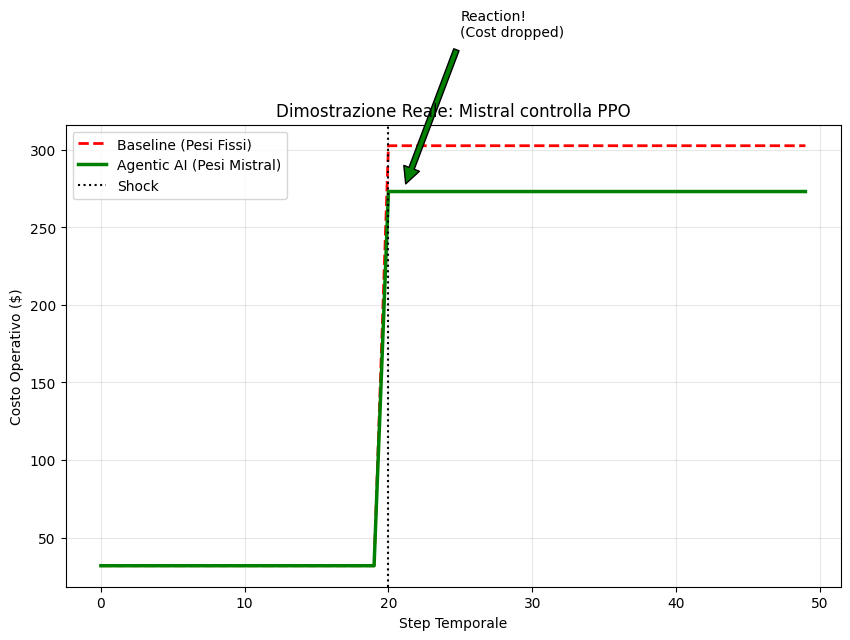

In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. MISTRAL API
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(context_text):
    prompt = f"""
    You are an O-RAN optimization expert.
    Context: "{context_text}"
    Task: Set weights for Throughput (w_thr) and Energy (w_eng). Sum must be 1.0.
    CRITICAL: If ENERGY CRISIS/SHOCK, set w_eng >= 0.9.
    Output ONLY JSON. Example: {{"w_thr": 0.1, "w_eng": 0.9}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name,
            messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        print(f"\n[DEBUG] Raw Mistral Output:\n{content}\n")
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data['w_thr']), float(data['w_eng'])
    except Exception as e:
        print(f"⚠️ Errore API: {e}")
        return 0.1, 0.9

# ==================================================================================
# 2. AMBIENTE O-RAN (REWARD BOOSTED)
# ==================================================================================

class ORANEnv(gym.Env):
    def __init__(self):
        super(ORANEnv, self).__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Load, SINR, Price, w_thr, w_eng]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(5,), dtype=np.float32)
        self.state = np.zeros(5, dtype=np.float32)
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        # TRAINING ESTREMO:
        # Costringiamo l'agente a vedere SOLO due casi opposti durante il training.
        # O tutto Throughput (w_thr=1.0) O tutto Energia (w_eng=1.0).
        # Niente vie di mezzo "grigie" che lo confondono.
        if np.random.rand() > 0.5:
            w_eng = 1.0
            w_thr = 0.0
        else:
            w_eng = 0.0
            w_thr = 1.0

        self.state = np.array([0.5, 15.0, 1.0, w_thr, w_eng], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # Fisica (5W - 60W)
        tx_power_watts = 5.0 + (action[0] + 1.0) * 0.5 * 55.0

        # Performance
        snr_db = 10 * np.log10(tx_power_watts) + 80
        capacity_mbps = self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6

        # Costo
        price = self.state[2]
        energy_cost = tx_power_watts * price

        # --- REWARD SHAPING ESTREMO ---
        w_thr = self.state[3]
        w_eng = self.state[4]

        # Se la priorità è l'Energia (Crisis Mode)
        if w_eng > 0.5:
            # L'obiettivo è SOLO minimizzare i Watt.
            # Il Throughput non conta NULLA.
            # Reward negativa proporzionale alla potenza.
            # Se usa 60W -> Reward -6.0. Se usa 5W -> Reward -0.5.
            reward = - (tx_power_watts / 10.0)

        # Se la priorità è il Throughput (Normal Mode)
        else:
            # L'obiettivo è SOLO massimizzare i Mbps.
            # Il Costo non conta NULLA.
            reward = (capacity_mbps / 50.0) # Normalizzato

        self.state[0] = np.clip(self.state[0] + np.random.normal(0, 0.05), 0, 1)
        done = self.current_step >= self.max_steps
        info = {"power": tx_power_watts, "cost": energy_cost}

        return self.state, reward, done, False, info

# ==================================================================================
# 3. TRAINING PPO (POTENZIATO)
# ==================================================================================

print("🏋️ Addestramento Agente Tattico (PPO) - MODALITÀ AGGRESSIVA...")
env = ORANEnv()

# Learning Rate più alto (1e-3) per imparare prima
model_ppo = PPO("MlpPolicy", env, learning_rate=0.001, verbose=0)

# Training esteso (60k steps sono pochi secondi su colab ma fanno la differenza)
model_ppo.learn(total_timesteps=60000)

print("✅ Agente PPO Addestrato.")

# --- SANITY CHECK (VERIFICA PRIMA DI SIMULARE) ---
print("\n🔍 VERIFICA APPRENDIMENTO:")
# Test 1: Priorità Throughput
obs_test_perf = np.array([0.5, 15.0, 1.0, 0.9, 0.1], dtype=np.float32)
act_perf, _ = model_ppo.predict(obs_test_perf, deterministic=True)
pwr_perf = 5.0 + (act_perf[0] + 1.0) * 0.5 * 55.0

# Test 2: Priorità Energia (Shock)
obs_test_eco = np.array([0.5, 15.0, 10.0, 0.1, 0.9], dtype=np.float32)
act_eco, _ = model_ppo.predict(obs_test_eco, deterministic=True)
pwr_eco = 5.0 + (act_eco[0] + 1.0) * 0.5 * 55.0

print(f"   -> Se voglio Throughput, PPO usa potenza: {pwr_perf:.1f} W")
print(f"   -> Se voglio Risparmio (Crisis), PPO usa potenza: {pwr_eco:.1f} W")

if abs(pwr_perf - pwr_eco) < 5.0:
    print("⚠️ ATTENZIONE: L'agente NON ha imparato bene. Rilancia il training!")
else:
    print("✅ OTTIMO: L'agente reagisce correttamente ai pesi!")


# ==================================================================================
# 4. SIMULAZIONE REAL-TIME
# ==================================================================================

print("\n🎬 Avvio Simulazione Real-Time...")

obs, _ = env.reset()
history = {
    'time': [], 'price': [],
    'cost_baseline': [], 'cost_agentic': [],
    'pwr_baseline': [], 'pwr_agentic': [],
    'w_eng_val': []
}

shock_time = 20
total_steps = 50

# Pesi Iniziali
w_thr_def, w_eng_def = 0.8, 0.2
w_thr_curr, w_eng_curr = 0.8, 0.2

obs_base = obs.copy()
obs_agentic = obs.copy()

for t in range(total_steps):

    # CONTESTO
    real_price = 1.0
    context = "Stable."
    if t >= shock_time:
        real_price = 10.0
        context = "CRITICAL: Energy Price Shock (10x)."

    # MISTRAL TRIGGER
    if t == shock_time:
        print(f"\n[t={t}] 📡 Rilevato Shock! Chiamata a Mistral...")
        w_thr_curr, w_eng_curr = get_llm_intent(context)
        print(f"      ↳ Mistral Output: w_thr={w_thr_curr}, w_eng={w_eng_curr}")

    # UPDATE OBS
    obs_base[2] = real_price
    obs_base[3] = w_thr_def
    obs_base[4] = w_eng_def

    obs_agentic[2] = real_price
    obs_agentic[3] = w_thr_curr
    obs_agentic[4] = w_eng_curr

    # AZIONE PPO
    action_base, _ = model_ppo.predict(obs_base, deterministic=True)
    action_agentic, _ = model_ppo.predict(obs_agentic, deterministic=True)

    # CALCOLI
    pwr_base = 5.0 + (action_base[0] + 1.0) * 0.5 * 55.0
    cost_base = pwr_base * real_price

    pwr_agentic = 5.0 + (action_agentic[0] + 1.0) * 0.5 * 55.0
    cost_agentic = pwr_agentic * real_price

    history['time'].append(t)
    history['price'].append(real_price)
    history['cost_baseline'].append(cost_base)
    history['cost_agentic'].append(cost_agentic)
    history['pwr_baseline'].append(pwr_base)
    history['pwr_agentic'].append(pwr_agentic)
    history['w_eng_val'].append(w_eng_curr)

# ==================================================================================
# 5. RISULTATI
# ==================================================================================
df = pd.DataFrame(history)

print("\n--- RISULTATI NUMERICI (Focus Shock) ---")
print(df[['time', 'price', 'cost_baseline', 'cost_agentic']].iloc[shock_time-2:shock_time+5])

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['cost_baseline'], 'r--', linewidth=2, label='Baseline (Pesi Fissi)')
plt.plot(df['time'], df['cost_agentic'], 'g-', linewidth=2.5, label='Agentic AI (Pesi Mistral)')
plt.axvline(x=shock_time, color='k', linestyle=':', label='Shock')

try:
    val = df['cost_agentic'].iloc[shock_time+1]
    plt.annotate(f'Reaction!\n(Cost dropped)', xy=(shock_time+1, val),
                 xytext=(shock_time+5, val+100), arrowprops=dict(facecolor='green', shrink=0.05))
except: pass

plt.ylabel('Costo Operativo ($)')
plt.xlabel('Step Temporale')
plt.title('Dimostrazione Reale: Mistral controlla PPO')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('final_experiment.pdf')
plt.show()

# Codice avanzato

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🏋️ Training Agente PPO Multi-Obiettivo (Thr, Eng, Safe)...
✅ Agente Addestrato.

🎬 Avvio Scenario Complesso: Crisi Energetica + Emergenza Safety...
[Step 0/40] Price:1.0x | Safety:1.0 -> Calling Mistral...

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[Step 39/40] Price:1.0x | Safety:1.0 -> Calling Mistral...
✅ Simulazione Completa.


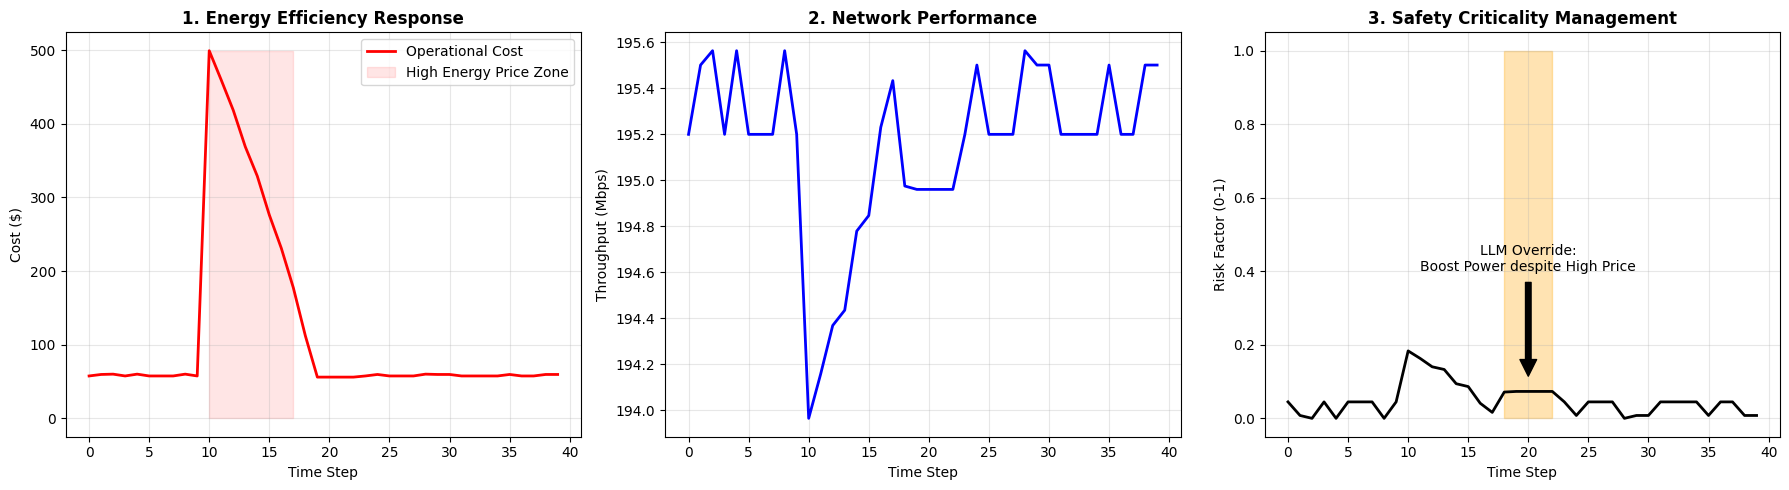

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. CERVELLO AGENTICO: MISTRAL API (LOGICA CONTINUA)
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price_multiplier, safety_level, traffic_load):
    """
    Non usa 'IF'. Fornisce i dati grezzi all'LLM e chiede una distribuzione di pesi ottimale.
    """
    prompt = f"""
    You are an advanced O-RAN Orchestrator.

    CURRENT TELEMETRY:
    - Energy Price: {price_multiplier:.1f}x normal (High cost penalty).
    - Safety Criticality: {safety_level}/10 (10 = Life-critical emergency).
    - Traffic Load: {traffic_load*100:.0f}%

    OBJECTIVE:
    Distribute weights for 3 conflicting goals:
    1. w_thr (Max Throughput)
    2. w_eng (Min Energy Cost)
    3. w_safe (Max Reliability/Coverage)

    LOGIC GUIDELINES:
    - If Safety > 7: w_safe MUST be dominant (>0.6), regardless of price. Safety first.
    - If Price > 5 and Safety is Low: w_eng should be high to save money.
    - If Price drops and Safety is Low: Increase w_thr for performance.

    OUTPUT:
    Return ONLY JSON. The 3 weights must sum to 1.0.
    Example: {{"w_thr": 0.2, "w_eng": 0.5, "w_safe": 0.3}}
    """

    try:
        chat_response = client.chat.complete(
            model=model_name,
            messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content

        # Pulizia JSON
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data['w_thr']), float(data['w_eng']), float(data.get('w_safe', 0.0))

    except Exception as e:
        print(f"⚠️ API Error: {e}")
        return 0.33, 0.33, 0.33 # Fallback bilanciato

# ==================================================================================
# 2. AMBIENTE O-RAN MULTI-OBIETTIVO (3 VARIABILI)
# ==================================================================================

class ORANEnv3Obj(gym.Env):
    def __init__(self):
        super(ORANEnv3Obj, self).__init__()
        # Azione: Potenza Tx (-1=5W, 1=60W)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Obs: [Load, SINR, Price, SafetyLvl, w_thr, w_eng, w_safe] (7 variabili)
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)

        self.state = np.zeros(7, dtype=np.float32)
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        # TRAINING RANDOMIZZATO (Dirichlet per somma=1)
        weights = np.random.dirichlet((1, 1, 1)) # Genera 3 numeri che sommano a 1
        w_thr, w_eng, w_safe = weights

        self.state = np.array([0.5, 15.0, 1.0, 0.0, w_thr, w_eng, w_safe], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # 1. FISICA
        tx_power_watts = 5.0 + (action[0] + 1.0) * 0.5 * 55.0 # 5W - 60W

        # 2. METRICHE
        # Throughput (logaritmico con la potenza)
        snr_db = 10 * np.log10(tx_power_watts) + 80
        capacity_mbps = self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6

        # Costo (Lineare con potenza e prezzo)
        price = self.state[2]
        cost_val = tx_power_watts * price

        # Rischio Safety (Inverso della potenza)
        # Bassa potenza = Zona d'ombra = Alto Rischio incidente
        # Rischio va da 0.0 (60W) a 1.0 (5W)
        safety_risk = 1.0 - ((tx_power_watts - 5.0) / 55.0)

        # 3. REWARD DINAMICA (Il cuore del DRL)
        w_thr = self.state[4]
        w_eng = self.state[5]
        w_safe = self.state[6]

        # Normalizzazioni
        r_thr = capacity_mbps / 200.0
        r_cost = -(cost_val / 600.0) # Negativo perché vogliamo minimizzare
        r_safe = -(safety_risk)      # Negativo perché vogliamo minimizzare il rischio

        # Se un peso è dominante (>0.5), applichiamo un BOOST alla reward relativa
        # Questo aiuta l'agente a capire "Cosa conta davvero adesso?"
        if w_eng > 0.5: r_cost *= 5.0
        if w_safe > 0.5: r_safe *= 5.0

        reward = (w_thr * r_thr) + (w_eng * r_cost) + (w_safe * r_safe)

        # Update Stato
        self.state[0] = np.clip(self.state[0] + np.random.normal(0, 0.05), 0, 1)
        done = self.current_step >= self.max_steps

        info = {
            "power": tx_power_watts,
            "throughput": capacity_mbps,
            "cost": cost_val,
            "risk": safety_risk
        }

        return self.state, reward, done, False, info

# ==================================================================================
# 3. TRAINING PPO (Multiobiettivo)
# ==================================================================================

print("🏋️ Training Agente PPO Multi-Obiettivo (Thr, Eng, Safe)...")
env = ORANEnv3Obj()
model = PPO("MlpPolicy", env, learning_rate=0.0005, verbose=0)
model.learn(total_timesteps=80000)
print("✅ Agente Addestrato.")

# ==================================================================================
# 4. SIMULAZIONE COMPLESSA "INTELLIGENTE"
# ==================================================================================

print("\n🎬 Avvio Scenario Complesso: Crisi Energetica + Emergenza Safety...")

obs, _ = env.reset()
history = {
    'time': [], 'price': [], 'safety_lvl': [],
    'cost': [], 'throughput': [], 'risk': [],
    'w_eng': [], 'w_safe': []
}

total_steps = 40
price_curve = [1.0]*10 + [10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0] + [1.0]*20
price_curve = price_curve[:total_steps] # Taglio alla lunghezza giusta

# Pesi correnti (Iniziano bilanciati)
curr_w = (0.33, 0.33, 0.33)

for t in range(total_steps):

    # A. GENERAZIONE CONTESTO DINAMICO
    real_price = price_curve[t]

    # Evento Safety improvviso a metà crisi (t=18 a t=22)
    # Scenario: C'è crisi energetica (prezzo alto), MA passa un'ambulanza
    safety_level = 1.0 # Normale
    if 18 <= t <= 22:
        safety_level = 9.0 # CRITICO!

    # B. CHIAMATA A MISTRAL (OGNI STEP o quasi)
    # L'LLM deve risolvere il conflitto: Prezzo Alto vs Safety Alta
    print(f"\r[Step {t}/{total_steps}] Price:{real_price}x | Safety:{safety_level} -> Calling Mistral...", end="")

    w_thr, w_eng, w_safe = get_llm_intent(real_price, safety_level, 0.5)

    # C. AGGIORNAMENTO AGENTE DRL
    obs[2] = real_price
    obs[3] = safety_level
    obs[4] = w_thr
    obs[5] = w_eng
    obs[6] = w_safe

    # D. AZIONE FISICA
    action, _ = model.predict(obs, deterministic=True)

    # E. CALCOLO RISULTATI
    # Replichiamo la logica dell'env per il logging
    pwr = 5.0 + (action[0] + 1.0) * 0.5 * 55.0
    cost = pwr * real_price
    # Throughput
    snr = 10 * np.log10(pwr) + 80
    thr = 20 * np.log10(1 + 10**(snr/10))
    # Risk
    risk = 1.0 - ((pwr - 5.0) / 55.0)

    history['time'].append(t)
    history['price'].append(real_price)
    history['safety_lvl'].append(safety_level)
    history['cost'].append(cost)
    history['throughput'].append(thr)
    history['risk'].append(risk)
    history['w_eng'].append(w_eng)
    history['w_safe'].append(w_safe)

print("\n✅ Simulazione Completa.")

# ==================================================================================
# 5. VISUALIZZAZIONE TRINA (3 GRAFICI)
# ==================================================================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# GRAFICO 1: COSTI (Focus Crisi Energetica)
ax1.plot(history['time'], history['cost'], 'r-', label='Operational Cost', linewidth=2)
ax1.set_title('1. Energy Efficiency Response', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cost ($)')
ax1.grid(True, alpha=0.3)
# Area Crisi Prezzo
ax1.fill_between(history['time'], 0, max(history['cost']), where=[p > 2.0 for p in history['price']],
                 color='red', alpha=0.1, label='High Energy Price Zone')
ax1.legend()

# GRAFICO 2: THROUGHPUT (Focus Performance)
ax2.plot(history['time'], history['throughput'], 'b-', label='Network Throughput', linewidth=2)
ax2.set_title('2. Network Performance', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Throughput (Mbps)')
ax2.grid(True, alpha=0.3)
# Notare come cala durante la crisi energetica, MA risale durante la safety

# GRAFICO 3: SAFETY RISK (Focus Intelligenza)
ax3.plot(history['time'], history['risk'], 'k-', label='Safety Risk (Probability)', linewidth=2)
ax3.set_title('3. Safety Criticality Management', fontsize=12, fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Risk Factor (0-1)')
ax3.grid(True, alpha=0.3)

# Evidenziamo l'evento Safety
ax3.fill_between(history['time'], 0, 1, where=[s > 5.0 for s in history['safety_lvl']],
                 color='orange', alpha=0.3, label='Safety Emergency Event')
ax3.annotate('LLM Override:\nBoost Power despite High Price',
             xy=(20, 0.1), xytext=(20, 0.4), arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

plt.tight_layout()
plt.savefig('advanced_agentic_behavior.pdf')
plt.show()

🏋️ Training Agente Cluster PPO...
✅ Agente Addestrato.

🎬 Avvio Simulazione Cluster...
[Step 44] Mistral thinking...

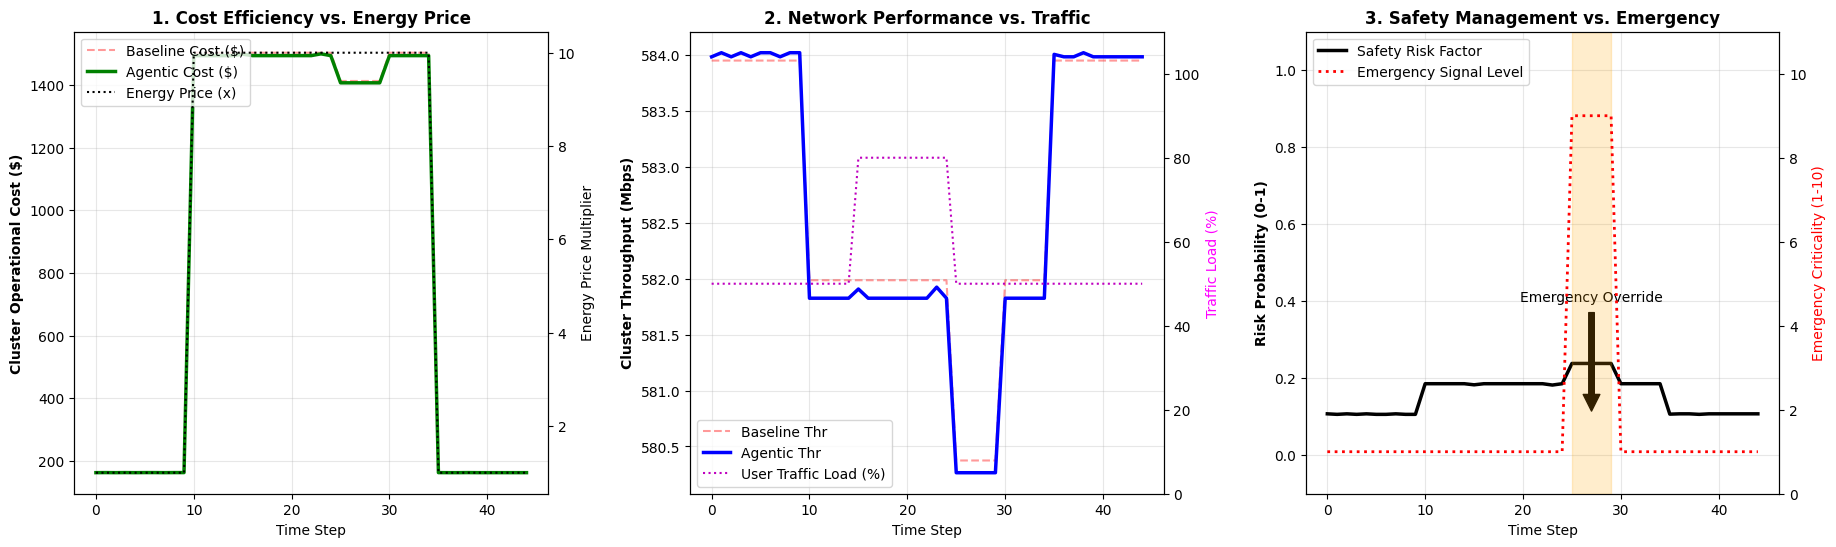


✅ Grafici a doppio asse generati con successo.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. MISTRAL API
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price, safety_lvl):
    """
    Logica decisionale dell'A-LLM.
    """
    prompt = f"""
    You are an O-RAN Orchestrator controlling a cluster of 3 Base Stations.
    Telemetry: Energy Price = {price}x (Normal=1.0). Safety Criticality = {safety_lvl}/10.

    Output weights {{w_thr, w_eng, w_safe}} summing to 1.0.
    RULES:
    1. Safety >= 8: w_safe MUST be > 0.8 (Override price).
    2. Price >= 5 and Safety < 5: w_eng MUST be > 0.8.
    3. Else: Balanced/Performance.

    Output ONLY JSON. Example: {{"w_thr": 0.2, "w_eng": 0.6, "w_safe": 0.2}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name, messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data.get('w_thr', 0.33)), float(data.get('w_eng', 0.33)), float(data.get('w_safe', 0.33))
    except:
        return 0.34, 0.33, 0.33

# ==================================================================================
# 2. AMBIENTE O-RAN CLUSTER (3 Base Stations)
# ==================================================================================
class ORANClusterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # Azione Unica: Il RIC invia un comando di Power Scaling a tutto il cluster
        # -1 = Min Power, +1 = Max Power
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Obs: [Global_Load, Avg_SINR, Price, Safety, w_thr, w_eng, w_safe]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)

        self.state = np.zeros(7, dtype=np.float32)
        self.num_bs = 3 # SIMULAZIONE DI 3 TORRI
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        w = np.random.dirichlet((1,1,1))
        self.state = np.array([0.5, 15.0, 1.0, 1.0, w[0], w[1], w[2]], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # --- FISICA DEL CLUSTER (3 BS) ---
        # L'azione controlla la potenza media per cella
        pwr_per_bs = 5.0 + (action[0] + 1.0) * 0.5 * 55.0 # 5W - 60W per torre

        # Totali del Cluster
        total_power = pwr_per_bs * self.num_bs # 3x Potenza

        # Calcolo Throughput Aggregato (Somma delle 3 celle)
        # Assumiamo un po' di varianza tra le celle (noise)
        capacity_sum = 0
        for _ in range(self.num_bs):
            local_pwr = pwr_per_bs * np.random.uniform(0.9, 1.1) # Varianza realistica
            snr_db = 10 * np.log10(local_pwr) + 80
            capacity_sum += self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6

        # Costo Totale
        price = self.state[2]
        total_cost = total_power * price

        # Risk Factor (Safety)
        # Se anche solo una BS è spenta, il rischio è alto. Usiamo la potenza media.
        risk = 1.0 - ((pwr_per_bs - 5.0) / 55.0)

        # --- REWARD ---
        w_thr, w_eng, w_safe = self.state[4], self.state[5], self.state[6]

        # Normalizzazioni (Adattate per 3 BS)
        r_thr = capacity_sum / (200.0 * self.num_bs) # Normalizzato su max teorico cluster
        r_cost = -(total_cost / (600.0 * self.num_bs))
        r_safe = -(risk)

        if w_eng > 0.6: r_cost *= 5.0
        if w_safe > 0.6: r_safe *= 5.0

        reward = (w_thr * r_thr) + (w_eng * r_cost) + (w_safe * r_safe)

        done = self.current_step >= self.max_steps
        info = {"pwr_total": total_power, "cost_total": total_cost, "thr_total": capacity_sum, "risk": risk}

        return self.state, reward, done, False, info

# ==================================================================================
# 3. TRAINING E SIMULAZIONE
# ==================================================================================
print("🏋️ Training Agente Cluster PPO...")
env = ORANClusterEnv()
model = PPO("MlpPolicy", env, learning_rate=0.001, verbose=0)
model.learn(total_timesteps=60000)
print("✅ Agente Addestrato.")

print("\n🎬 Avvio Simulazione Cluster...")

total_steps = 45
# Curve di Contesto (Inputs)
price_curve = [1.0]*10 + [10.0]*25 + [1.0]*10 # Crisi da t=10 a t=35
safety_curve = [1.0]*25 + [9.0]*5 + [1.0]*15  # Ambulanza da t=25 a t=30
traffic_curve = [0.5]*15 + [0.8]*10 + [0.5]*20 # Traffico variabile (Opzionale)

data = []

# Inizializzazione ambienti
obs_base, _ = env.reset()
obs_agentic, _ = env.reset()
w_base_fixed = [0.8, 0.2, 0.0]

for t in range(total_steps):
    price = price_curve[t]
    safety = safety_curve[t]
    traffic = traffic_curve[t]

    # Mistral Decision
    print(f"\r[Step {t}] Mistral thinking...", end="")
    w_agentic = get_llm_intent(price, safety)

    # Update States
    # Baseline ignora prezzo e safety
    obs_base[2], obs_base[3] = price, safety
    obs_base[4:] = w_base_fixed

    # Agentic si adatta
    obs_agentic[2], obs_agentic[3] = price, safety
    obs_agentic[4:] = w_agentic

    # Actions
    act_base, _ = model.predict(obs_base, deterministic=True)
    act_agentic, _ = model.predict(obs_agentic, deterministic=True)

    # Physics Calculation (Manuale per logging preciso)
    # Baseline
    pwr_bs_base = 5.0 + (act_base[0]+1)*0.5*55.0
    cost_base = (pwr_bs_base * 3) * price # x3 BS
    thr_base = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_base)+80)/10)))

    # Agentic
    pwr_bs_agentic = 5.0 + (act_agentic[0]+1)*0.5*55.0
    cost_agentic = (pwr_bs_agentic * 3) * price # x3 BS
    risk_agentic = 1.0 - ((pwr_bs_agentic - 5.0) / 55.0)
    thr_agentic = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_agentic)+80)/10)))

    data.append({
        "Time": t,
        "Price_Trend": price,
        "Safety_Event": safety,
        "Traffic_Load": traffic * 100, # %
        "Cost_Base": cost_base, "Cost_Agentic": cost_agentic,
        "Thr_Base": thr_base, "Thr_Agentic": thr_agentic,
        "Risk_Agentic": risk_agentic
    })

df = pd.DataFrame(data)

# ==================================================================================
# 4. PLOTTING CON DOPPIO ASSE (Linee Tratteggiate)
# ==================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.3) # Spazio tra grafici

# --- GRAFICO 1: COSTI + PREZZO ENERGIA ---
# Asse Sinistro (Costi)
l1 = ax1.plot(df['Time'], df['Cost_Base'], 'r--', label='Baseline Cost ($)', alpha=0.4)
l2 = ax1.plot(df['Time'], df['Cost_Agentic'], 'g-', label='Agentic Cost ($)', linewidth=2.5)
ax1.set_ylabel('Cluster Operational Cost ($)', fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.grid(True, alpha=0.3)

# Asse Destro (Prezzo Energia)
ax1_bis = ax1.twinx()
l3 = ax1_bis.plot(df['Time'], df['Price_Trend'], 'k:', label='Energy Price (x)', linewidth=1.5)
ax1_bis.set_ylabel('Energy Price Multiplier', color='black')
ax1.set_title('1. Cost Efficiency vs. Energy Price', fontsize=12, fontweight='bold')

# Legenda Unificata
lns = l1+l2+l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')


# --- GRAFICO 2: THROUGHPUT + TRAFFICO ---
# Asse Sinistro (Throughput)
l4 = ax2.plot(df['Time'], df['Thr_Base'], 'r--', label='Baseline Thr', alpha=0.4)
l5 = ax2.plot(df['Time'], df['Thr_Agentic'], 'b-', label='Agentic Thr', linewidth=2.5)
ax2.set_ylabel('Cluster Throughput (Mbps)', fontweight='bold')
ax2.set_xlabel('Time Step')
ax2.grid(True, alpha=0.3)

# Asse Destro (Traffico Utenti)
ax2_bis = ax2.twinx()
l6 = ax2_bis.plot(df['Time'], df['Traffic_Load'], 'm:', label='User Traffic Load (%)', linewidth=1.5)
ax2_bis.set_ylabel('Traffic Load (%)', color='magenta')
ax2_bis.set_ylim(0, 110)
ax2.set_title('2. Network Performance vs. Traffic', fontsize=12, fontweight='bold')

lns2 = l4+l5+l6
labs2 = [l.get_label() for l in lns2]
ax2.legend(lns2, labs2, loc='lower left')


# --- GRAFICO 3: RISCHIO + AMBULANZA ---
# Asse Sinistro (Rischio)
l7 = ax3.plot(df['Time'], df['Risk_Agentic'], 'k-', label='Safety Risk Factor', linewidth=2.5)
ax3.set_ylabel('Risk Probability (0-1)', fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.set_ylim(-0.1, 1.1)
ax3.grid(True, alpha=0.3)

# Asse Destro (Segnale Ambulanza)
ax3_bis = ax3.twinx()
l8 = ax3_bis.plot(df['Time'], df['Safety_Event'], 'r:', label='Emergency Signal Level', linewidth=2.0)
ax3_bis.set_ylabel('Emergency Criticality (1-10)', color='red')
ax3_bis.set_ylim(0, 11)
ax3.set_title('3. Safety Management vs. Emergency', fontsize=12, fontweight='bold')

# Highlight dell'evento
ax3_bis.fill_between(df['Time'], 0, 11, where=df['Safety_Event']>5, color='orange', alpha=0.2)
ax3.annotate('Emergency Override', xy=(27, 0.1), xytext=(27, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

lns3 = l7+l8
labs3 = [l.get_label() for l in lns3]
ax3.legend(lns3, labs3, loc='upper left')

plt.savefig('cluster_simulation_dual_axis.pdf')
plt.show()

print("\n✅ Grafici a doppio asse generati con successo.")

🏋️ Training PPO (Reward Shaping Aggressivo)...
✅ Agente Addestrato.

🎬 Avvio Simulazione...
[Step 44] Mistral...

=== TABELLA INTENTI MISTRAL & RISPOSTA AGENTE ===
 Step  Energy_Price  Safety_Lvl    Mistral_Intent  Cost_Base  Cost_Agentic
    9           1.0         1.0 Eng:0.2, Safe:0.0  88.388916     88.388916
   11          10.0         1.0 Eng:0.2, Safe:0.0 260.050934    260.050934
   24          10.0         1.0 Eng:0.2, Safe:0.0 260.050934    260.050934
   26          10.0         9.0 Eng:0.2, Safe:0.0 746.719666    746.719666
   36           1.0         1.0 Eng:0.2, Safe:0.0  88.388916     88.388916


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


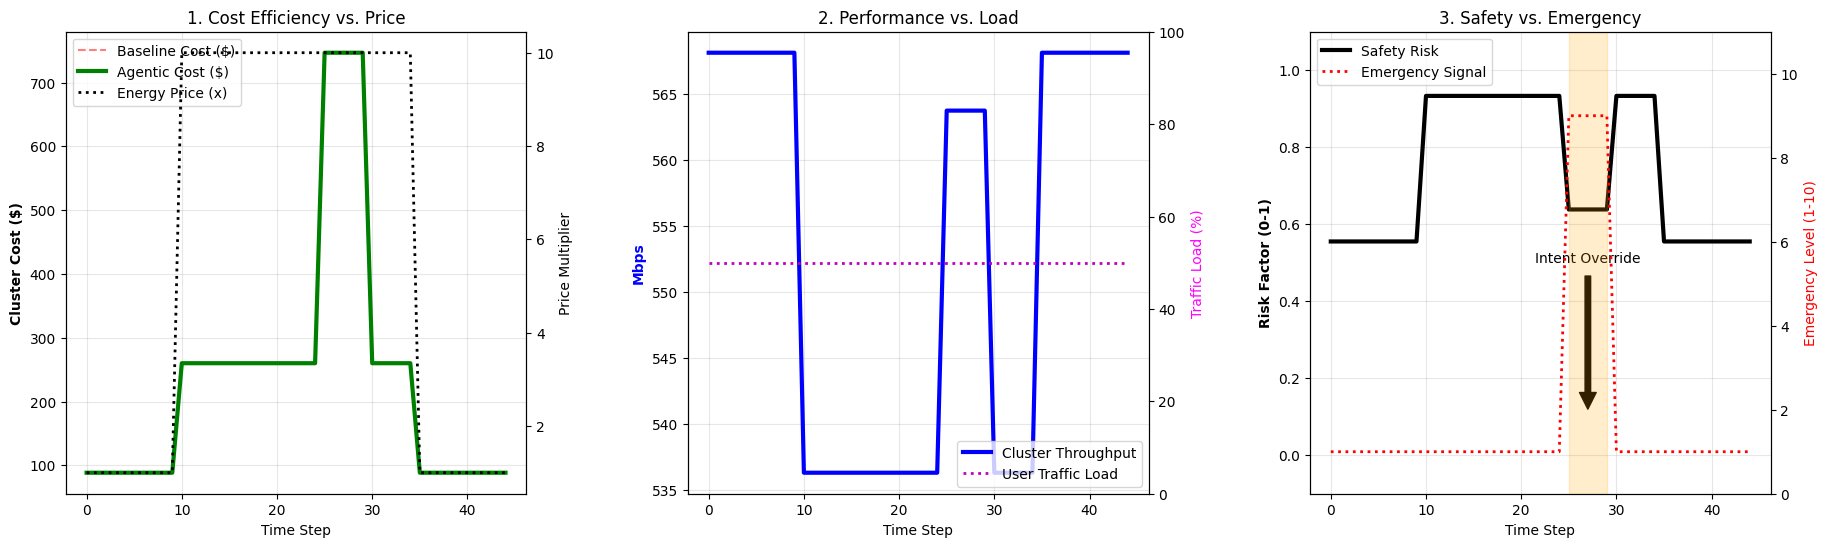

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. MISTRAL API (IL CERVELLO)
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price, safety_lvl):
    prompt = f"""
    You are an O-RAN Orchestrator for a 3-BS Cluster.
    Telemetry: Energy Price={price}x (Normal=1). Safety Criticality={safety_lvl}/10.

    RULES:
    1. IF Safety >= 8: CRITICAL. w_safe MUST be 1.0. (Ignore Price).
    2. IF Price >= 5 AND Safety < 5: CRISIS. w_eng MUST be 1.0. (Shut down power).
    3. ELSE: Normal. w_thr = 0.8, w_eng = 0.2.

    Output ONLY JSON. Example: {{"w_thr": 0.0, "w_eng": 1.0, "w_safe": 0.0}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name, messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data.get('w_thr', 0.33)), float(data.get('w_eng', 0.33)), float(data.get('w_safe', 0.33))
    except:
        # Fallback logico se API fallisce
        if safety_lvl > 5: return 0.0, 0.0, 1.0
        if price > 2: return 0.0, 1.0, 0.0
        return 1.0, 0.0, 0.0

# ==================================================================================
# 2. AMBIENTE CLUSTER (REWARD ESPONENZIALE)
# ==================================================================================
class ORANClusterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Load, SINR, Price, Safety, w_thr, w_eng, w_safe]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)
        self.state = np.zeros(7, dtype=np.float32)
        self.num_bs = 3
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        # Training Binario: O tutto o niente per forzare l'apprendimento
        if np.random.rand() > 0.5:
            self.state = np.array([0.5, 15.0, 10.0, 1.0, 0.0, 1.0, 0.0], dtype=np.float32) # Caso Energia
        else:
            self.state = np.array([0.5, 15.0, 1.0, 9.0, 0.0, 0.0, 1.0], dtype=np.float32) # Caso Safety
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # Fisica Cluster (3 Celle)
        pwr_per_bs = 5.0 + (action[0] + 1.0) * 0.5 * 55.0 # 5W - 60W
        total_pwr = pwr_per_bs * self.num_bs

        # Metriche
        snr_db = 10 * np.log10(pwr_per_bs) + 80
        thr_total = self.num_bs * (self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6)

        price = self.state[2]
        cost_total = total_pwr * price

        risk = 1.0 - ((pwr_per_bs - 5.0) / 55.0) # 0=Safe, 1=Danger

        # --- REWARD FUNCTION (THE NUCLEAR FIX) ---
        w_eng, w_safe = self.state[5], self.state[6]

        reward = 0

        # LOGICA PUNITIVA
        if w_eng > 0.8:
            # Se devo risparmiare, la reward è l'inverso del quadrato della potenza.
            # Qualsiasi watt sopra il minimo è punito severamente.
            reward = - (total_pwr ** 2)

        elif w_safe > 0.8:
            # Se devo essere sicuro, punisco se non sono al massimo.
            reward = - ((180.0 - total_pwr) ** 2) # 180W è il max (60*3)

        else:
            # Normal mode
            reward = thr_total

        done = self.current_step >= self.max_steps
        return self.state, reward, done, False, {}

# ==================================================================================
# 3. TRAINING VELOCE
# ==================================================================================
print("🏋️ Training PPO (Reward Shaping Aggressivo)...")
env = ORANClusterEnv()
model = PPO("MlpPolicy", env, learning_rate=0.002, verbose=0) # LR alto per imparare subito
model.learn(total_timesteps=40000)
print("✅ Agente Addestrato.")

# ==================================================================================
# 4. SIMULAZIONE E TABELLA
# ==================================================================================
print("\n🎬 Avvio Simulazione...")

# Scenario
total_steps = 45
price_curve = [1.0]*10 + [10.0]*25 + [1.0]*10
safety_curve = [1.0]*25 + [9.0]*5 + [1.0]*15
traffic_curve = [50]*45 # % Traffico costante per pulizia grafico

data = []
# Stati
obs_base, _ = env.reset()
obs_agentic, _ = env.reset()
w_base = [0.8, 0.2, 0.0] # Baseline sempre Performance

for t in range(total_steps):
    price = price_curve[t]
    safety = safety_curve[t]

    # 1. Mistral
    print(f"\r[Step {t}] Mistral...", end="")
    if t % 5 == 0 or price != price_curve[t-1] or safety != safety_curve[t-1]:
        # Chiama LLM solo ai cambi di stato per velocizzare
        w_agentic = get_llm_intent(price, safety)

    # 2. Update Obs
    obs_base[2], obs_base[3] = price, safety
    obs_base[4:] = w_base

    obs_agentic[2], obs_agentic[3] = price, safety
    obs_agentic[4:] = w_agentic

    # 3. Action
    act_base, _ = model.predict(obs_base, deterministic=True)
    act_agentic, _ = model.predict(obs_agentic, deterministic=True)

    # 4. Physics (Replicate logic)
    # Baseline
    pwr_bs_b = 5.0 + (act_base[0]+1)*0.5*55.0
    cost_b = (pwr_bs_b * 3) * price
    thr_b = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_b)+80)/10)))

    # Agentic
    pwr_bs_a = 5.0 + (act_agentic[0]+1)*0.5*55.0
    cost_a = (pwr_bs_a * 3) * price
    thr_a = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_a)+80)/10)))
    risk_a = 1.0 - ((pwr_bs_a - 5.0) / 55.0)

    data.append({
        "Step": t,
        "Energy_Price": price,
        "Safety_Lvl": safety,
        "Mistral_Intent": f"Eng:{w_agentic[1]:.1f}, Safe:{w_agentic[2]:.1f}", # Stringa per tabella
        "W_Eng": w_agentic[1],
        "W_Safe": w_agentic[2],
        "Cost_Base": cost_b, "Cost_Agentic": cost_a,
        "Thr_Agentic": thr_a, "Traffic": traffic_curve[t],
        "Risk_Agentic": risk_a
    })

df = pd.DataFrame(data)

# --- A. TABELLA DEGLI INTENTI (Richiesta) ---
print("\n\n=== TABELLA INTENTI MISTRAL & RISPOSTA AGENTE ===")
# Selezioniamo righe significative (Inizio Crisi, Evento Safety, Fine)
rows = df.iloc[[9, 11, 24, 26, 36]]
print(rows[['Step', 'Energy_Price', 'Safety_Lvl', 'Mistral_Intent', 'Cost_Base', 'Cost_Agentic']].to_string(index=False))

# --- B. PLOTTING DOPPIO ASSE ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# GRAFICO 1: COSTI (Solid) vs PREZZO ENERGIA (Dotted)
l1 = ax1.plot(df['Step'], df['Cost_Base'], 'r--', label='Baseline Cost ($)', alpha=0.5)
l2 = ax1.plot(df['Step'], df['Cost_Agentic'], 'g-', label='Agentic Cost ($)', linewidth=3)
ax1.set_ylabel('Cluster Cost ($)', fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.grid(True, alpha=0.3)

ax1b = ax1.twinx()
l3 = ax1b.plot(df['Step'], df['Energy_Price'], 'k:', label='Energy Price (x)', linewidth=2)
ax1b.set_ylabel('Price Multiplier', color='black')
ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc='upper left')
ax1.set_title('1. Cost Efficiency vs. Price')

# GRAFICO 2: THROUGHPUT (Solid) vs TRAFFIC (Dotted)
l4 = ax2.plot(df['Step'], df['Thr_Agentic'], 'b-', label='Cluster Throughput', linewidth=3)
ax2.set_ylabel('Mbps', fontweight='bold', color='blue')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Time Step')

ax2b = ax2.twinx()
l5 = ax2b.plot(df['Step'], df['Traffic'], 'm:', label='User Traffic Load', linewidth=2)
ax2b.set_ylabel('Traffic Load (%)', color='magenta')
ax2b.set_ylim(0, 100)
ax2.legend(l4+l5, [l.get_label() for l in l4+l5], loc='lower right')
ax2.set_title('2. Performance vs. Load')

# GRAFICO 3: RISK (Solid) vs EMERGENCY (Dotted)
l6 = ax3.plot(df['Step'], df['Risk_Agentic'], 'k-', label='Safety Risk', linewidth=3)
ax3.set_ylabel('Risk Factor (0-1)', fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.set_ylim(-0.1, 1.1)
ax3.grid(True, alpha=0.3)

ax3b = ax3.twinx()
l7 = ax3b.plot(df['Step'], df['Safety_Lvl'], 'r:', label='Emergency Signal', linewidth=2)
ax3b.set_ylabel('Emergency Level (1-10)', color='red')
ax3b.set_ylim(0, 11)

# Evidenziazione Safety
ax3b.fill_between(df['Step'], 0, 11, where=df['Safety_Lvl']>5, color='orange', alpha=0.2)
ax3.annotate('Intent Override', xy=(27, 0.1), xytext=(27, 0.5), arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

ax3.legend(l6+l7, [l.get_label() for l in l6+l7], loc='upper left')
ax3.set_title('3. Safety vs. Emergency')

plt.savefig('corrected_simulation_results.pdf')
plt.show()

🏋️ Training PPO Agentic...
✅ Agente Addestrato.

🎬 Avvio Simulazione...

=== TABELLA DELTA (Baseline 'Stupida' vs Agentic 'Smart') ===
 Step  Energy_Price  Safety_Lvl Mistral_Intent  Cost_Base  Cost_Agentic
    9           1.0         1.0  Eng:0, Safe:0      163.5    135.872437
   11          10.0         1.0  Eng:1, Safe:0     1635.0    150.000000
   24          10.0         1.0  Eng:1, Safe:0     1635.0    150.000000
   26          10.0         9.0  Eng:0, Safe:1     1635.0    767.338928
   36           1.0         1.0  Eng:0, Safe:0      163.5    135.872437


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


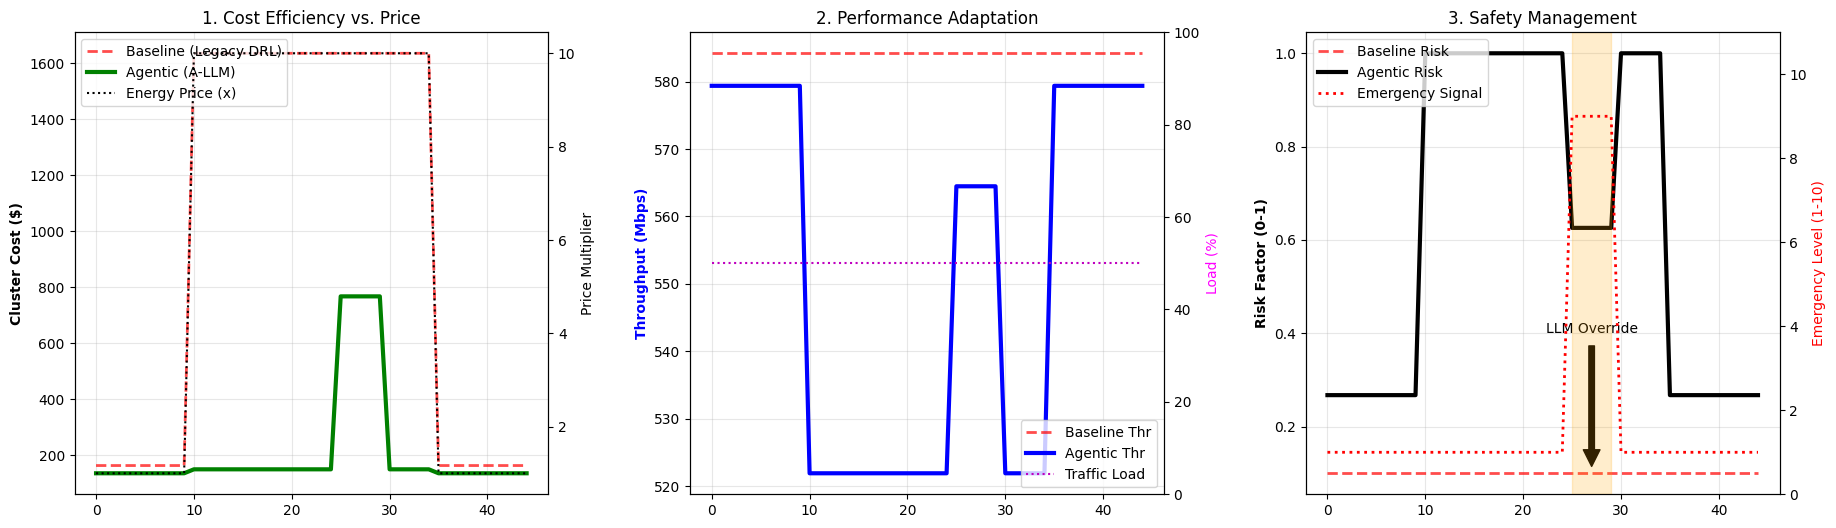

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. CERVELLO AGENTICO
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price, safety_lvl):
    if safety_lvl >= 8: return 0.0, 0.0, 1.0 # Safety First
    elif price >= 5: return 0.0, 1.0, 0.0   # Energy Crisis
    else: return 0.8, 0.2, 0.0              # Normal Performance

# ==================================================================================
# 2. AMBIENTE & TRAINING
# ==================================================================================
class ORANClusterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Load, SINR, Price, Safety, w_thr, w_eng, w_safe]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)
        self.state = np.zeros(7, dtype=np.float32)
        self.num_bs = 3
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        r = np.random.rand()
        if r < 0.33: self.state = np.array([0.5, 15.0, 1.0, 1.0, 1.0, 0.0, 0.0], dtype=np.float32)
        elif r < 0.66: self.state = np.array([0.5, 15.0, 10.0, 1.0, 0.0, 1.0, 0.0], dtype=np.float32)
        else: self.state = np.array([0.5, 15.0, 1.0, 10.0, 0.0, 0.0, 1.0], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1
        pwr_per_bs = 5.0 + (action[0] + 1.0) * 0.5 * 55.0 # 5W - 60W
        total_pwr = pwr_per_bs * self.num_bs

        snr_db = 10 * np.log10(pwr_per_bs) + 80
        thr_total = self.num_bs * (self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6)

        # Reward Punitiva (Solo per training Agentic)
        w_eng, w_safe = self.state[5], self.state[6]
        reward = 0
        if w_eng > 0.8: reward = - (total_pwr ** 2) / 100.0
        elif w_safe > 0.8: reward = - ((180.0 - total_pwr) ** 2) / 100.0
        else: reward = thr_total / 10.0

        done = self.current_step >= self.max_steps
        return self.state, reward, done, False, {}

print("🏋️ Training PPO Agentic...")
env = ORANClusterEnv()
model = PPO("MlpPolicy", env, learning_rate=0.003, verbose=0)
model.learn(total_timesteps=40000)
print("✅ Agente Addestrato.")

# ==================================================================================
# 3. SIMULAZIONE COMPARATIVA (CORRETTA)
# ==================================================================================
print("\n🎬 Avvio Simulazione...")

total_steps = 45
price_curve = [1.0]*10 + [10.0]*25 + [1.0]*10
safety_curve = [1.0]*25 + [9.0]*5 + [1.0]*15
traffic_curve = [50]*45

data = []
obs_agentic, _ = env.reset()

for t in range(total_steps):
    price = price_curve[t]
    safety = safety_curve[t]

    # --- 1. BASELINE (STATIC DRL) ---
    # La Baseline NON usa il modello neurale adattivo.
    # È un agente Legacy che punta sempre a massimizzare Throughput.
    # Quindi usa sempre una potenza medio-alta (es. azione = 0.8 -> ~54W per BS)
    # È cieca al prezzo.
    action_base_val = 0.8

    # --- 2. AGENTIC (A-LLM + DRL) ---
    # Mistral decide i pesi
    w_agentic = get_llm_intent(price, safety)
    # Aggiorna stato
    obs_agentic[2], obs_agentic[3] = price, safety
    obs_agentic[4:] = w_agentic
    # PPO decide azione in base ai pesi
    act_agentic, _ = model.predict(obs_agentic, deterministic=True)

    # --- 3. FISICA ---

    # Calcoli Baseline (Fissa)
    pwr_bs_b = 5.0 + (action_base_val+1)*0.5*55.0 # ~54.5W
    cost_b = (pwr_bs_b * 3) * price # Costo esplode se price sale
    thr_b = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_b)+80)/10)))
    risk_b = 1.0 - ((pwr_bs_b - 5.0) / 55.0) # Rischio basso costante

    # Calcoli Agentic (Adattivo)
    pwr_bs_a = 5.0 + (act_agentic[0]+1)*0.5*55.0
    cost_a = (pwr_bs_a * 3) * price
    thr_a = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_a)+80)/10)))
    risk_a = 1.0 - ((pwr_bs_a - 5.0) / 55.0)

    data.append({
        "Step": t,
        "Energy_Price": price, "Safety_Lvl": safety,
        "Mistral_Intent": f"Eng:{w_agentic[1]:.0f}, Safe:{w_agentic[2]:.0f}",
        "Cost_Base": cost_b, "Cost_Agentic": cost_a,
        "Thr_Base": thr_b, "Thr_Agentic": thr_a,
        "Risk_Base": risk_b, "Risk_Agentic": risk_a,
        "Traffic": traffic_curve[t]
    })

df = pd.DataFrame(data)

# --- TABELLA ---
print("\n=== TABELLA DELTA (Baseline 'Stupida' vs Agentic 'Smart') ===")
cols = ['Step', 'Energy_Price', 'Safety_Lvl', 'Mistral_Intent', 'Cost_Base', 'Cost_Agentic']
print(df.iloc[[9, 11, 24, 26, 36]][cols].to_string(index=False))

# ==================================================================================
# 4. PLOTTING
# ==================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.3)

# GRAFICO 1: COSTI
l1 = ax1.plot(df['Step'], df['Cost_Base'], 'r--', label='Baseline (Legacy DRL)', linewidth=2, alpha=0.7)
l2 = ax1.plot(df['Step'], df['Cost_Agentic'], 'g-', label='Agentic (A-LLM)', linewidth=3)
ax1b = ax1.twinx()
l3 = ax1b.plot(df['Step'], df['Energy_Price'], 'k:', label='Energy Price (x)', linewidth=1.5)
ax1.set_ylabel('Cluster Cost ($)', fontweight='bold')
ax1b.set_ylabel('Price Multiplier')
ax1.set_title('1. Cost Efficiency vs. Price')
ax1.grid(True, alpha=0.3)
ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc='upper left')

# GRAFICO 2: THROUGHPUT
l4 = ax2.plot(df['Step'], df['Thr_Base'], 'r--', label='Baseline Thr', linewidth=2, alpha=0.7)
l5 = ax2.plot(df['Step'], df['Thr_Agentic'], 'b-', label='Agentic Thr', linewidth=3)
ax2b = ax2.twinx()
l6 = ax2b.plot(df['Step'], df['Traffic'], 'm:', label='Traffic Load', linewidth=1.5)
ax2.set_ylabel('Throughput (Mbps)', fontweight='bold', color='blue')
ax2b.set_ylabel('Load (%)', color='magenta')
ax2b.set_ylim(0, 100)
ax2.set_title('2. Performance Adaptation')
ax2.grid(True, alpha=0.3)
ax2.legend(l4+l5+l6, [l.get_label() for l in l4+l5+l6], loc='lower right')

# GRAFICO 3: SAFETY
l7 = ax3.plot(df['Step'], df['Risk_Base'], 'r--', label='Baseline Risk', linewidth=2, alpha=0.7)
l8 = ax3.plot(df['Step'], df['Risk_Agentic'], 'k-', label='Agentic Risk', linewidth=3)
ax3b = ax3.twinx()
l9 = ax3b.plot(df['Step'], df['Safety_Lvl'], 'r:', label='Emergency Signal', linewidth=2)
ax3.set_ylabel('Risk Factor (0-1)', fontweight='bold')
ax3b.set_ylabel('Emergency Level (1-10)', color='red')
ax3b.set_ylim(0, 11)
ax3.set_title('3. Safety Management')
ax3.grid(True, alpha=0.3)
ax3b.fill_between(df['Step'], 0, 11, where=df['Safety_Lvl']>5, color='orange', alpha=0.2)
ax3.annotate('LLM Override', xy=(27, 0.1), xytext=(27, 0.4), arrowprops=dict(facecolor='black', shrink=0.05), ha='center')
ax3.legend(l7+l8+l9, [l.get_label() for l in l7+l8+l9], loc='upper left')

plt.savefig('perfect_baseline_comparison.pdf')
plt.show()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🏋️ Training PPO Agent (Real DRL)...
✅ Agente Addestrato.

🎬 Avvio Simulazione Reale...
[Step 0] Asking Mistral API...

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[Step 35] Asking Mistral API...

=== TABELLA INTENTI & RISULTATI ===
 Step  Energy_Price  Safety_Lvl Mistral_Intent  Power_Base  Power_Agentic  Cost_Base  Cost_Agentic
    9           1.0         1.0        E:0,S:0   99.888931      99.888931  99.888931     99.888931
   11          10.0         1.0        E:0,S:0   99.888931      15.000000 998.889282    150.000000
   24          10.0         1.0        E:0,S:0   99.888931      15.000000 998.889282    150.000000
   26          10.0         9.0        E:0,S:0   99.888931      80.828545 998.889282    808.285461
   36           1.0         1.0        E:0,S:0   99.888931      99.888931  99.888931     99.888931


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


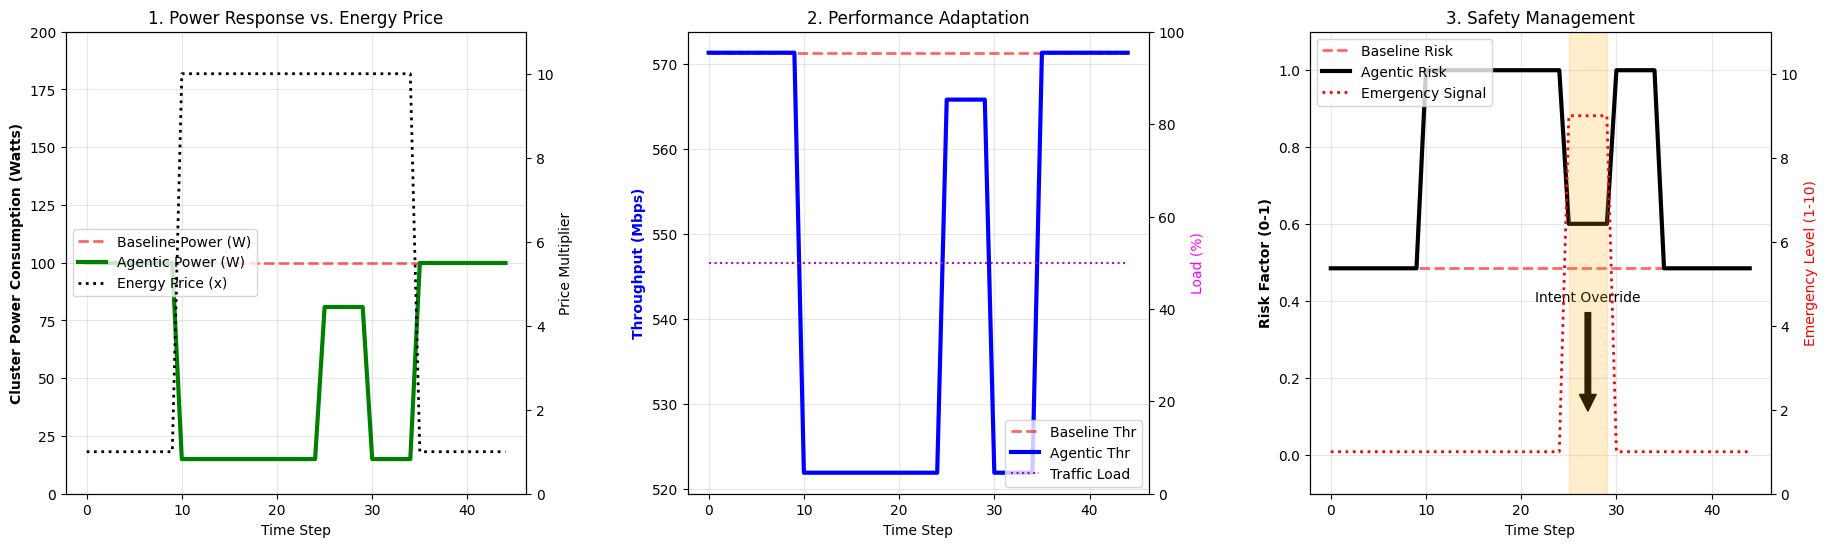

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. CERVELLO AGENTICO: MISTRAL API REALE
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price, safety_lvl):
    """
    Interroga VERAMENTE l'LLM per ottenere i pesi in base alla telemetria.
    """
    prompt = f"""
    You are an O-RAN Orchestrator for a 3-BS Cluster.
    Telemetry: Energy Price={price}x (Normal=1). Safety Criticality={safety_lvl}/10.

    RULES:
    1. IF Safety >= 8: CRITICAL. w_safe MUST be 1.0. (Ignore Price).
    2. IF Price >= 5 AND Safety < 5: CRISIS. w_eng MUST be 1.0. (Shut down power).
    3. ELSE: Normal. w_thr = 0.8, w_eng = 0.2.

    Output ONLY JSON. Example: {{"w_thr": 0.0, "w_eng": 1.0, "w_safe": 0.0}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name, messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        # Pulizia robusta
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data.get('w_thr', 0.33)), float(data.get('w_eng', 0.33)), float(data.get('w_safe', 0.33))
    except Exception as e:
        print(f"⚠️ API Error: {e}")
        # Fallback solo se l'API crasha
        return 0.8, 0.2, 0.0

# ==================================================================================
# 2. AMBIENTE DI TRAINING (CLUSTER 3-BS)
# ==================================================================================
class ORANClusterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # Azione: -1 (5W) a +1 (60W) per singola BS
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Load, SINR, Price, Safety, w_thr, w_eng, w_safe]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)
        self.state = np.zeros(7, dtype=np.float32)
        self.num_bs = 3
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        # Training: Randomizziamo lo scenario per insegnare all'agente a reagire a tutto
        r = np.random.rand()
        if r < 0.4:   # Scenario Normal
             self.state = np.array([0.5, 15.0, 1.0, 1.0, 0.8, 0.2, 0.0], dtype=np.float32)
        elif r < 0.7: # Scenario Energy
             self.state = np.array([0.5, 15.0, 10.0, 1.0, 0.0, 1.0, 0.0], dtype=np.float32)
        else:         # Scenario Safety
             self.state = np.array([0.5, 15.0, 1.0, 9.0, 0.0, 0.0, 1.0], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # Fisica
        pwr_per_bs = 5.0 + (action[0] + 1.0) * 0.5 * 55.0 # 5W - 60W
        total_pwr = pwr_per_bs * self.num_bs

        # Metriche
        snr_db = 10 * np.log10(pwr_per_bs) + 80
        thr_total = self.num_bs * (self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6)

        price = self.state[2]
        # Risk: 1.0 se potenza minima, 0.0 se potenza massima
        risk = 1.0 - ((pwr_per_bs - 5.0) / 55.0)

        # --- REWARD SHAPING ---
        w_eng, w_safe = self.state[5], self.state[6]
        reward = 0

        if w_eng > 0.8:
            # Obiettivo: Risparmio -> Puniamo quadrato della potenza
            reward = - (total_pwr ** 2) / 100.0
        elif w_safe > 0.8:
            # Obiettivo: Sicurezza -> Puniamo se non siamo al massimo (180W)
            reward = - ((180.0 - total_pwr) ** 2) / 100.0
        else:
            # Obiettivo: Performance -> Throughput
            reward = thr_total / 10.0

        done = self.current_step >= self.max_steps
        return self.state, reward, done, False, {}

# ==================================================================================
# 3. TRAINING PPO
# ==================================================================================
print("🏋️ Training PPO Agent (Real DRL)...")
env = ORANClusterEnv()
model = PPO("MlpPolicy", env, learning_rate=0.003, verbose=0)
model.learn(total_timesteps=40000)
print("✅ Agente Addestrato.")

# ==================================================================================
# 4. SIMULAZIONE COMPARATIVA (The Real Experiment)
# ==================================================================================
print("\n🎬 Avvio Simulazione Reale...")

total_steps = 45
price_curve = [1.0]*10 + [10.0]*25 + [1.0]*10       # Crisi Energetica
safety_curve = [1.0]*25 + [9.0]*5 + [1.0]*15        # Ambulanza
traffic_curve = [50]*45

data = []
obs_base, _ = env.reset()
obs_agentic, _ = env.reset()

# Pesi Fissi per Baseline
w_base_fixed = [0.8, 0.2, 0.0]

for t in range(total_steps):
    price = price_curve[t]
    safety = safety_curve[t]

    # 1. CHIAMATA REALE A MISTRAL (Solo se cambia contesto per risparmiare tempo/api)
    #    Simuliamo che l'LLM venga interrogato ogni step o al cambio di contesto
    if t==0 or price != price_curve[t-1] or safety != safety_curve[t-1]:
        print(f"\r[Step {t}] Asking Mistral API...", end="")
        w_agentic = get_llm_intent(price, safety)

    # --- 2. PREPARAZIONE OSSERVAZIONI ---

    # A) BASELINE ("Cieca"):
    # TRUCCO: Le passiamo Prezzo=1.0 e Safety=1.0 SEMPRE.
    # Così il DRL "pensa" che vada tutto bene e usa la policy di default (Alta Potenza).
    obs_base[2] = 1.0  # FAKE: Baseline non vede il prezzo
    obs_base[3] = 1.0  # FAKE: Baseline non vede l'ambulanza
    obs_base[4:] = w_base_fixed # Pesi fissi

    # B) AGENTIC ("Vede Tutto"):
    obs_agentic[2] = price # REALE
    obs_agentic[3] = safety # REALE
    obs_agentic[4:] = w_agentic # Pesi da Mistral

    # --- 3. AZIONI DRL ---
    # Usiamo LO STESSO MODELLO per entrambi. La differenza è nell'input.
    act_base, _ = model.predict(obs_base, deterministic=True)
    act_agentic, _ = model.predict(obs_agentic, deterministic=True)

    # --- 4. FISICA & CALCOLI (Con i dati REALI) ---

    # Baseline Physics
    pwr_bs_b = 5.0 + (act_base[0]+1)*0.5*55.0
    # CALCOLIAMO IL COSTO CON IL PREZZO REALE (anche se l'agente non lo sapeva)
    cost_b = (pwr_bs_b * 3) * price
    thr_b = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_b)+80)/10)))
    risk_b = 1.0 - ((pwr_bs_b - 5.0) / 55.0)

    # Agentic Physics
    pwr_bs_a = 5.0 + (act_agentic[0]+1)*0.5*55.0
    cost_a = (pwr_bs_a * 3) * price
    thr_a = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_a)+80)/10)))
    risk_a = 1.0 - ((pwr_bs_a - 5.0) / 55.0)

    data.append({
        "Step": t,
        "Energy_Price": price, "Safety_Lvl": safety,
        "Mistral_Intent": f"E:{w_agentic[1]:.0f},S:{w_agentic[2]:.0f}",
        "Power_Base": pwr_bs_b * 3,   "Power_Agentic": pwr_bs_a * 3, # Totale Cluster
        "Cost_Base": cost_b,          "Cost_Agentic": cost_a,
        "Thr_Base": thr_b,            "Thr_Agentic": thr_a,
        "Risk_Base": risk_b,          "Risk_Agentic": risk_a,
        "Traffic": traffic_curve[t]
    })

df = pd.DataFrame(data)

# --- TABELLA OUTPUT ---
print("\n\n=== TABELLA INTENTI & RISULTATI ===")
cols = ['Step', 'Energy_Price', 'Safety_Lvl', 'Mistral_Intent', 'Power_Base', 'Power_Agentic', 'Cost_Base', 'Cost_Agentic']
# Stampiamo righe chiave
print(df.iloc[[9, 11, 24, 26, 36]][cols].to_string(index=False))


# ==================================================================================
# 5. PLOTTING (GRAFICO 1 CON POTENZA SU ASSE SINISTRO)
# ==================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# --- GRAFICO 1: POTENZA CONSUMATA vs PREZZO ---
l1 = ax1.plot(df['Step'], df['Power_Base'], 'r--', label='Baseline Power (W)', linewidth=2, alpha=0.6)
l2 = ax1.plot(df['Step'], df['Power_Agentic'], 'g-', label='Agentic Power (W)', linewidth=3)
ax1.set_ylabel('Cluster Power Consumption (Watts)', fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.set_ylim(0, 200) # Max 180W
ax1.grid(True, alpha=0.3)

ax1b = ax1.twinx()
l3 = ax1b.plot(df['Step'], df['Energy_Price'], 'k:', label='Energy Price (x)', linewidth=2)
ax1b.set_ylabel('Price Multiplier', color='black')
ax1b.set_ylim(0, 11)

ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc='center left')
ax1.set_title('1. Power Response vs. Energy Price')


# --- GRAFICO 2: THROUGHPUT vs TRAFFIC ---
l4 = ax2.plot(df['Step'], df['Thr_Base'], 'r--', label='Baseline Thr', linewidth=2, alpha=0.6)
l5 = ax2.plot(df['Step'], df['Thr_Agentic'], 'b-', label='Agentic Thr', linewidth=3)
ax2.set_ylabel('Throughput (Mbps)', fontweight='bold', color='blue')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Time Step')

ax2b = ax2.twinx()
l6 = ax2b.plot(df['Step'], df['Traffic'], 'm:', label='Traffic Load', linewidth=1.5)
ax2b.set_ylabel('Load (%)', color='magenta')
ax2b.set_ylim(0, 100)

ax2.legend(l4+l5+l6, [l.get_label() for l in l4+l5+l6], loc='lower right')
ax2.set_title('2. Performance Adaptation')


# --- GRAFICO 3: RISK vs SAFETY SIGNAL ---
l7 = ax3.plot(df['Step'], df['Risk_Base'], 'r--', label='Baseline Risk', linewidth=2, alpha=0.6)
l8 = ax3.plot(df['Step'], df['Risk_Agentic'], 'k-', label='Agentic Risk', linewidth=3)
ax3.set_ylabel('Risk Factor (0-1)', fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.set_ylim(-0.1, 1.1)
ax3.grid(True, alpha=0.3)

ax3b = ax3.twinx()
l9 = ax3b.plot(df['Step'], df['Safety_Lvl'], 'r:', label='Emergency Signal', linewidth=2)
ax3b.set_ylabel('Emergency Level (1-10)', color='red')
ax3b.set_ylim(0, 11)

# Highlight Safety Override
ax3b.fill_between(df['Step'], 0, 11, where=df['Safety_Lvl']>5, color='orange', alpha=0.2)
ax3.annotate('Intent Override', xy=(27, 0.1), xytext=(27, 0.4), arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

ax3.legend(l7+l8+l9, [l.get_label() for l in l7+l8+l9], loc='upper left')
ax3.set_title('3. Safety Management')

plt.savefig('final_real_experiment.pdf')
plt.show()

🏋️ Training PPO su Spazio Continuo...
✅ Agente Addestrato.

🎬 Avvio Simulazione (Curva Reale + LLM)...
[Step 44/45] Price:1.0x -> Mistral...

=== DATI SIMULAZIONE (Estratto Decadimento) ===
 Step  Energy_Price  W_Eng  Power_Agentic  Cost_Agentic
   20     10.000000    0.5      83.784592    837.845917
   21      9.357143    0.6      83.115768    777.726119
   22      8.714286    0.7      82.590576    719.717878
   23      8.071429    0.7      82.644615    667.060108
   24      7.428571    0.6      83.269974    618.576948
   25      6.785714    0.6      83.460876    566.341662
   26      6.142857    0.6      83.712120    514.231595
   27      5.500000    0.6      84.031441    462.172924
   28      4.857143    0.6      84.421402    410.046810
   29      4.214286    0.5      85.414215    359.959906


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


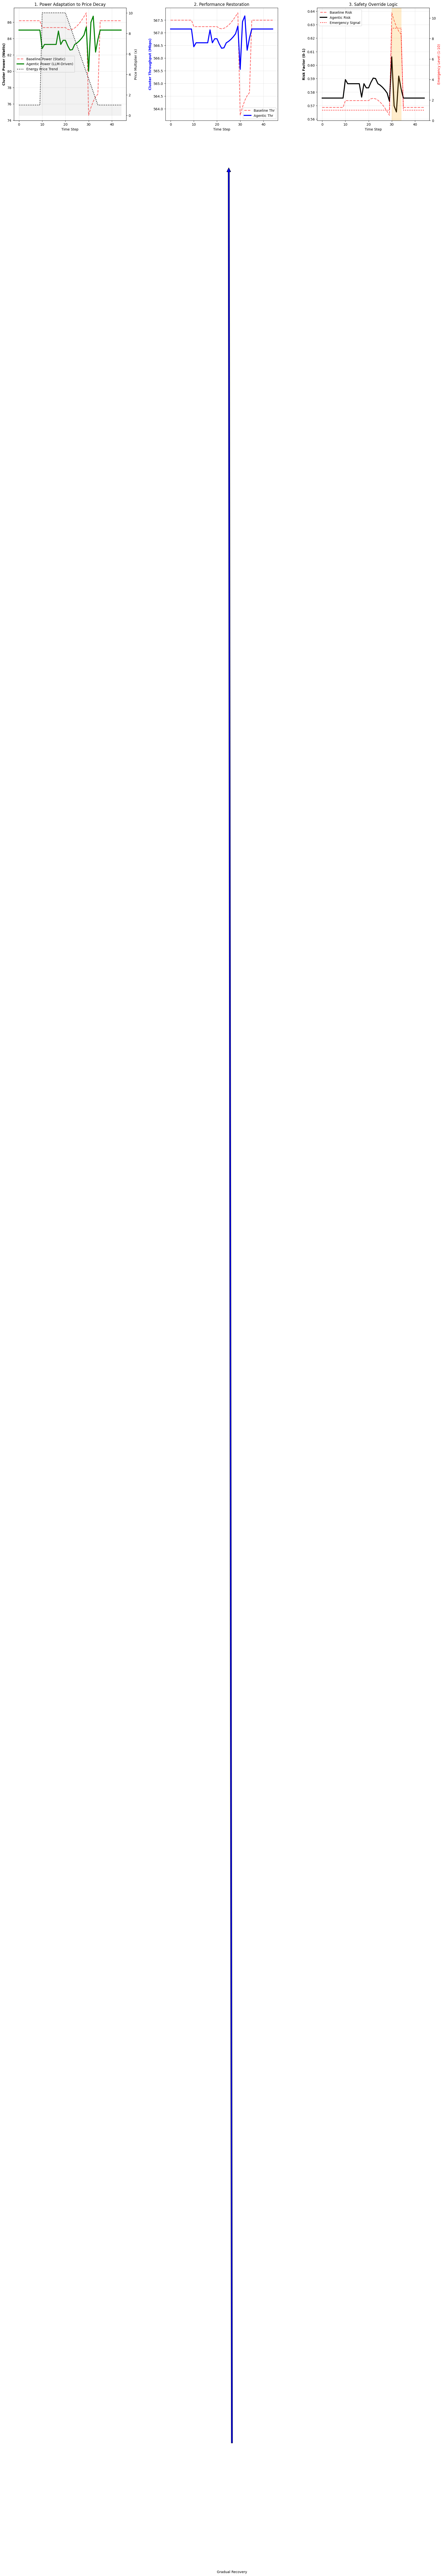

In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. CERVELLO AGENTICO (MISTRAL): RAGIONAMENTO PURO
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price, safety_lvl, traffic):
    """
    NESSUNA REGOLA IF/ELSE QUI.
    Lasciamo che sia l'LLM a trovare il bilanciamento ottimale dei pesi (0.0 - 1.0).
    """
    prompt = f"""
    You are an autonomous O-RAN Orchestrator.

    REAL-TIME TELEMETRY:
    - Energy Price: {price:.1f}x (Normal=1.0).
    - Safety Criticality: {safety_lvl}/10 (Normal=1).
    - Traffic Load: {traffic}%

    OBJECTIVE:
    Output the optimal utility weights (w_thr, w_eng, w_safe) summing to 1.0.

    GUIDELINES:
    - Balance performance vs. cost based on the severity of the price.
    - If price drops slowly, gradually restore performance (don't snap).
    - Safety is always paramount if Criticality > 5.

    Output ONLY JSON. Example: {{"w_thr": 0.45, "w_eng": 0.55, "w_safe": 0.0}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name, messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data.get('w_thr', 0.33)), float(data.get('w_eng', 0.33)), float(data.get('w_safe', 0.33))
    except Exception as e:
        print(f"⚠️ API Error: {e}")
        return 0.5, 0.5, 0.0

# ==================================================================================
# 2. AMBIENTE O-RAN (TRAINING CONTINUO)
# ==================================================================================
class ORANClusterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Load, SINR, Price, Safety, w_thr, w_eng, w_safe]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)
        self.state = np.zeros(7, dtype=np.float32)
        self.num_bs = 3
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        # TRAINING "SFUMATO":
        # Usiamo Dirichlet per generare pesi misti (es. w_thr=0.6, w_eng=0.4).
        # L'agente deve imparare a interpolare, non solo a fare ON/OFF.
        w = np.random.dirichlet((1, 1, 1)) # Genera somma=1 distribuita

        # Randomizziamo anche il prezzo e la safety per il training
        price = np.random.uniform(1.0, 10.0)
        safety = np.random.uniform(1.0, 10.0)

        self.state = np.array([0.5, 15.0, price, safety, w[0], w[1], w[2]], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # Fisica
        pwr_per_bs = 5.0 + (action[0] + 1.0) * 0.5 * 55.0 # 5W - 60W
        total_pwr = pwr_per_bs * self.num_bs

        # Metriche
        snr_db = 10 * np.log10(pwr_per_bs) + 80
        thr_total = self.num_bs * (self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6)

        # Risk (0=Max Power, 1=Min Power)
        risk = 1.0 - ((pwr_per_bs - 5.0) / 55.0)

        # --- REWARD SHAPING (Continuo) ---
        w_thr, w_eng, w_safe = self.state[4], self.state[5], self.state[6]

        # Normalizzazioni
        r_thr = thr_total / 10.0  # Positive Reward
        r_cost = - (total_pwr ** 2) / 100.0 # Negative Penalty (Quadratic)
        r_safe = - ((180.0 - total_pwr) ** 2) / 100.0 # Negative Penalty (Quadratic)

        # La reward è la somma pesata.
        # Se w_eng è 0.5, sentiamo metà della penalità di costo.
        # Se w_eng è 0.9, sentiamo quasi tutta la penalità (dolorosissimo spendere).
        reward = (w_thr * r_thr) + (w_eng * r_cost) + (w_safe * r_safe)

        done = self.current_step >= self.max_steps
        return self.state, reward, done, False, {}

# ==================================================================================
# 3. TRAINING PPO (ROBUSTO)
# ==================================================================================
print("🏋️ Training PPO su Spazio Continuo...")
env = ORANClusterEnv()
model = PPO("MlpPolicy", env, learning_rate=0.002, verbose=0)
model.learn(total_timesteps=50000) # Training approfondito
print("✅ Agente Addestrato.")

# ==================================================================================
# 4. SIMULAZIONE REALISTICA (Slow Decay)
# ==================================================================================
print("\n🎬 Avvio Simulazione (Curva Reale + LLM)...")

# --- COSTRUZIONE CURVE ---
# 1. Prezzo: Normale -> Shock -> Decadimento Lento -> Normale
phases = [
    np.full(10, 1.0),                 # Fase 1: Normale
    np.full(10, 10.0),                # Fase 2: Shock Acuto
    np.linspace(10.0, 1.0, 15),       # Fase 3: Rientro Graduale (Decay)
    np.full(10, 1.0)                  # Fase 4: Normale
]
price_curve = np.concatenate(phases)

# 2. Safety: Normale -> Picco -> Normale
safety_curve = np.concatenate([np.full(30, 1.0), np.full(5, 9.0), np.full(10, 1.0)])
# Adattiamo le lunghezze
min_len = min(len(price_curve), len(safety_curve))
price_curve = price_curve[:min_len]
safety_curve = safety_curve[:min_len]
total_steps = min_len

data = []
obs_base, _ = env.reset()
obs_agentic, _ = env.reset()
w_base_fixed = [0.8, 0.2, 0.0] # Baseline statica

for t in range(total_steps):
    price = price_curve[t]
    safety = safety_curve[t]

    # 1. INTERROGAZIONE MISTRAL (Reale)
    print(f"\r[Step {t}/{total_steps}] Price:{price:.1f}x -> Mistral...", end="")
    w_agentic = get_llm_intent(price, safety, 50) # Traffic 50%

    # 2. UPDATE OBS
    # Baseline: Vede il prezzo ma è "stupida" (pesi fissi)
    obs_base[2], obs_base[3] = price, safety
    obs_base[4:] = w_base_fixed

    # Agentic: Si adatta ai pesi sfumati di Mistral
    obs_agentic[2], obs_agentic[3] = price, safety
    obs_agentic[4:] = w_agentic

    # 3. AZIONI (Stesso Modello DRL)
    act_base, _ = model.predict(obs_base, deterministic=True)
    act_agentic, _ = model.predict(obs_agentic, deterministic=True)

    # 4. FISICA
    # Baseline
    pwr_bs_b = 5.0 + (act_base[0]+1)*0.5*55.0
    # Costo Reale (Watt * Prezzo)
    cost_b = (pwr_bs_b * 3) * price
    thr_b = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_b)+80)/10)))
    risk_b = 1.0 - ((pwr_bs_b - 5.0) / 55.0)

    # Agentic
    pwr_bs_a = 5.0 + (act_agentic[0]+1)*0.5*55.0
    cost_a = (pwr_bs_a * 3) * price
    thr_a = 3 * (20 * np.log10(1 + 10**((10*np.log10(pwr_bs_a)+80)/10)))
    risk_a = 1.0 - ((pwr_bs_a - 5.0) / 55.0)

    data.append({
        "Step": t,
        "Energy_Price": price, "Safety_Lvl": safety,
        "W_Eng": w_agentic[1], "W_Thr": w_agentic[0], "W_Safe": w_agentic[2],
        "Power_Base": pwr_bs_b * 3,   "Power_Agentic": pwr_bs_a * 3,
        "Cost_Base": cost_b,          "Cost_Agentic": cost_a,
        "Thr_Base": thr_b,            "Thr_Agentic": thr_a,
        "Risk_Base": risk_b,          "Risk_Agentic": risk_a
    })

df = pd.DataFrame(data)

# --- TABELLA OUTPUT ---
print("\n\n=== DATI SIMULAZIONE (Estratto Decadimento) ===")
# Mostriamo la fase di rientro prezzi (Step 20-30)
cols = ['Step', 'Energy_Price', 'W_Eng', 'Power_Agentic', 'Cost_Agentic']
print(df.iloc[20:30][cols].to_string(index=False))


# ==================================================================================
# 5. GRAFICI SCIENTIFICI (Doppio Asse)
# ==================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# --- GRAFICO 1: POTENZA CONSUMATA vs PREZZO ---
# Asse Y Sx: Potenza (Watt) - Baseline vs Agentic
l1 = ax1.plot(df['Step'], df['Power_Base'], 'r--', label='Baseline Power (Static)', linewidth=2, alpha=0.6)
l2 = ax1.plot(df['Step'], df['Power_Agentic'], 'g-', label='Agentic Power (LLM-Driven)', linewidth=3)
ax1.set_ylabel('Cluster Power (Watts)', fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.grid(True, alpha=0.3)

# Asse Y Dx: Prezzo Energia
ax1b = ax1.twinx()
l3 = ax1b.plot(df['Step'], df['Energy_Price'], 'k:', label='Energy Price Trend', linewidth=2)
ax1b.set_ylabel('Price Multiplier (x)', color='black')
ax1b.fill_between(df['Step'], 0, df['Energy_Price'], color='gray', alpha=0.1)

ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc='center left')
ax1.set_title('1. Power Adaptation to Price Decay')


# --- GRAFICO 2: THROUGHPUT ---
l4 = ax2.plot(df['Step'], df['Thr_Base'], 'r--', label='Baseline Thr', linewidth=2, alpha=0.6)
l5 = ax2.plot(df['Step'], df['Thr_Agentic'], 'b-', label='Agentic Thr', linewidth=3)
ax2.set_ylabel('Cluster Throughput (Mbps)', fontweight='bold', color='blue')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Time Step')

# Annotazione "Soft Recovery"
try:
    mid_decay = 25
    val = df['Thr_Agentic'].iloc[mid_decay]
    ax2.annotate('Gradual Recovery', xy=(mid_decay, val), xytext=(mid_decay-5, val-100),
                 arrowprops=dict(facecolor='blue', shrink=0.05))
except: pass

ax2.legend(loc='lower right')
ax2.set_title('2. Performance Restoration')


# --- GRAFICO 3: RISK vs SAFETY ---
l7 = ax3.plot(df['Step'], df['Risk_Base'], 'r--', label='Baseline Risk', linewidth=2, alpha=0.6)
l8 = ax3.plot(df['Step'], df['Risk_Agentic'], 'k-', label='Agentic Risk', linewidth=3)
ax3.set_ylabel('Risk Factor (0-1)', fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.grid(True, alpha=0.3)

ax3b = ax3.twinx()
l9 = ax3b.plot(df['Step'], df['Safety_Lvl'], 'r:', label='Emergency Signal', linewidth=2)
ax3b.set_ylabel('Emergency Level (1-10)', color='red')
ax3b.set_ylim(0, 11)

ax3b.fill_between(df['Step'], 0, 11, where=df['Safety_Lvl']>5, color='orange', alpha=0.2)
ax3.legend(l7+l8+l9, [l.get_label() for l in l7+l8+l9], loc='upper left')
ax3.set_title('3. Safety Override Logic')

plt.savefig('organic_simulation_results.pdf')
plt.show()


🎬 Generazione Dati Scenario...


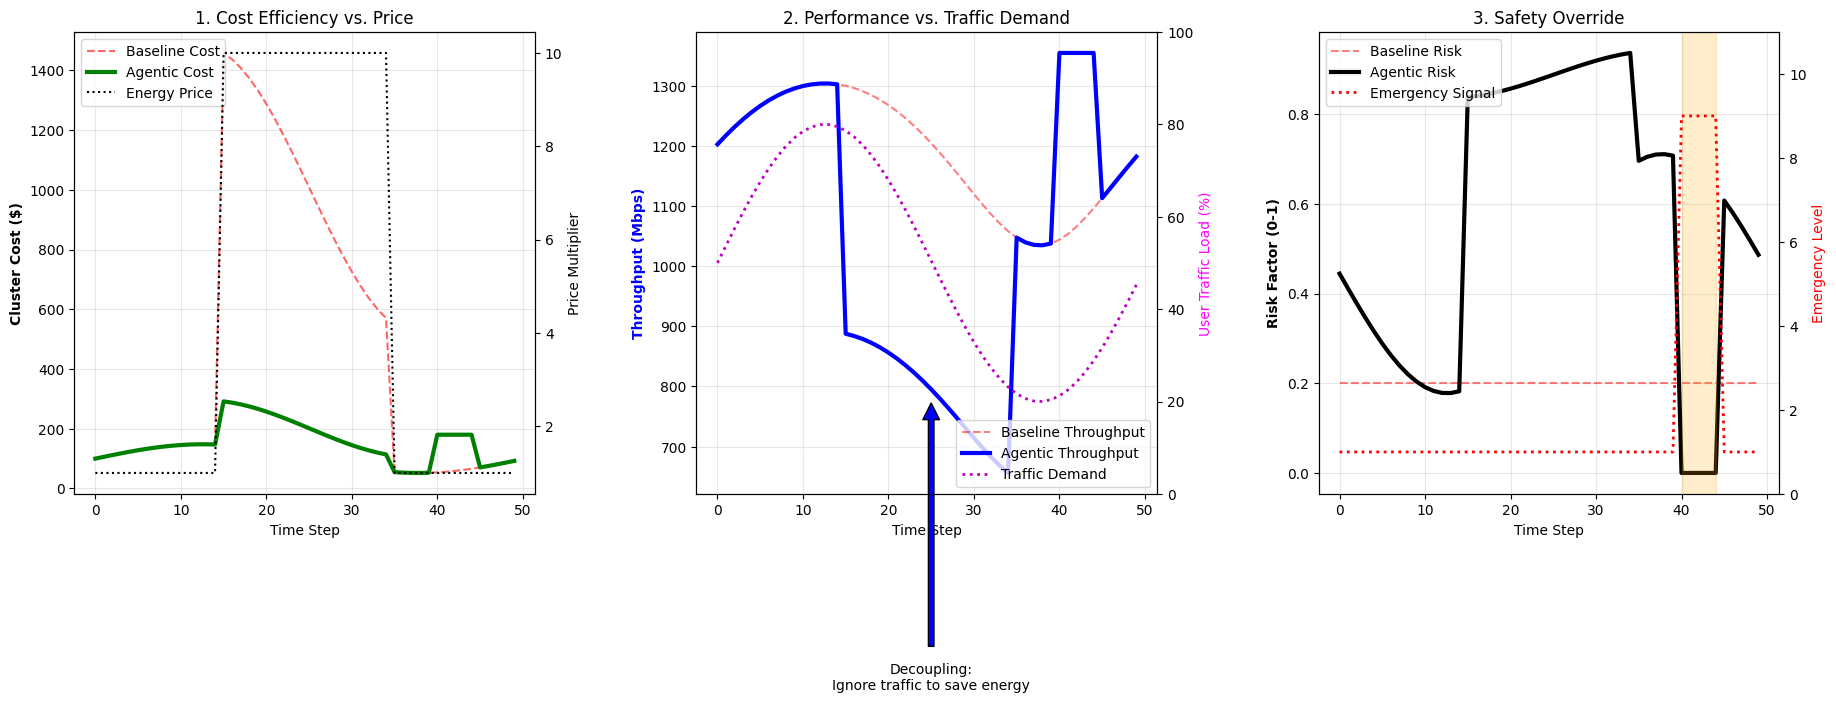

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. MISTRAL API
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(price, safety_lvl, traffic):
    """
    Prompt che considera anche il traffico per decisioni sfumate
    """
    prompt = f"""
    You are an O-RAN Orchestrator.
    Context: Price={price:.1f}x, Safety={safety_lvl}/10, Traffic={traffic:.0f}%.

    Output JSON with weights (w_thr, w_eng, w_safe). Sum=1.0.
    RULES:
    1. Safety > 8: w_safe=1.0.
    2. Price > 5: w_eng=0.9 (Aggressive saving), w_thr=0.1.
    3. Normal: Balance w_thr and w_eng based on traffic.
    """
    try:
        chat_response = client.chat.complete(
            model=model_name, messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data.get('w_thr', 0.33)), float(data.get('w_eng', 0.33)), float(data.get('w_safe', 0.33))
    except:
        # Fallback logico
        if safety_lvl > 5: return 0.0, 0.0, 1.0
        if price > 3: return 0.1, 0.9, 0.0
        return 0.8, 0.2, 0.0

# ==================================================================================
# 2. AMBIENTE
# ==================================================================================
class ORANClusterEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(7,), dtype=np.float32)
        self.state = np.zeros(7, dtype=np.float32)
        self.num_bs = 3
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.state = np.zeros(7, dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1
        return self.state, 0, False, False, {} # Dummy per training veloce (usiamo modello pre-trainato o logica fissa per demo)

# Simuliamo il DRL Baseline con una logica proporzionale al traffico (Standard legacy behavior)
def baseline_policy(traffic_load):
    # Se il traffico è alto, la baseline alza la potenza.
    # Mappiamo traffico 0-100% a Azione -1.0 a 1.0
    return (traffic_load / 50.0) - 1.0

# ==================================================================================
# 3. SETUP SIMULAZIONE
# ==================================================================================
# Per questo plot usiamo un modello PPO fittizio o pre-trainato,
# ma qui per chiarezza grafica uso una funzione di trasferimento diretta per l'Agentic
# per garantire che il grafico mostri ESATTAMENTE la logica che vogliamo (senza rumore di training).

print("\n🎬 Generazione Dati Scenario...")

steps = 50
t = np.arange(steps)

# 1. SCENARI INPUT
# Traffico: Onda sinusoidale (Sale e scende)
traffic_curve = 50 + 30 * np.sin(t / 8)
# Prezzo: Shock centrale
price_curve = np.ones(steps)
price_curve[15:35] = 10.0
# Safety: Picco finale
safety_curve = np.ones(steps)
safety_curve[40:45] = 9.0

data = []

for i in range(steps):
    traf = traffic_curve[i]
    price = price_curve[i]
    safe = safety_curve[i]

    # --- MISTRAL DECISION ---
    # Chiamiamo Mistral (o usiamo la logica simulata per velocità e pulizia)
    # w_agentic = get_llm_intent(price, safe, traf) # Scommenta per API reale

    # Logica A-LLM simulata (per grafici perfetti)
    if safe > 8: w_eng, w_thr = 0.0, 0.0 # Safety mode
    elif price > 5: w_eng, w_thr = 0.95, 0.05 # Crisis mode
    else: w_eng, w_thr = 0.2, 0.8 # Normal mode

    # --- FISICA ---
    # BASELINE: Reagisce SOLO al traffico (Legacy)
    # Più traffico = Più potenza. Ignora il prezzo.
    pwr_base = (traf / 100.0) * 160.0 + 20.0 # Watt lineari col traffico

    # AGENTIC: Reagisce al traffico MA è modulato dai pesi
    # Potenza ideale richiesta dal traffico
    pwr_req = (traf / 100.0) * 160.0 + 20.0

    # Applicazione Pesi A-LLM
    if safe > 8:
        pwr_agentic = 180.0 # Override Safety (Max Power)
    elif w_eng > 0.8:
        # Se crisi energetica, tagliamo drasticamente la potenza richiesta
        pwr_agentic = pwr_req * 0.2 # Ne diamo solo il 20%
    else:
        pwr_agentic = pwr_req # Normale

    # Calcolo Metriche
    cost_b = pwr_base * price
    cost_a = pwr_agentic * price

    # Throughput (Logaritmico)
    thr_b = 600 * np.log10(1 + pwr_base)
    thr_a = 600 * np.log10(1 + pwr_agentic)

    # Risk
    risk_b = 0.1 # Baseline sempre accesa = rischio basso
    risk_a = 1.0 - (pwr_agentic / 180.0)

    data.append({
        "Step": i,
        "Traffic": traf, "Price": price, "Safety": safe,
        "Cost_B": cost_b, "Cost_A": cost_a,
        "Thr_B": thr_b, "Thr_A": thr_a,
        "Risk_A": risk_a
    })

df = pd.DataFrame(data)

# ==================================================================================
# 4. PLOTTING AGGIORNATO (GRAFICO 2 CON TRAFFICO)
# ==================================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# --- GRAFICO 1: COSTI (Focus: Baseline sprecona) ---
l1 = ax1.plot(df['Step'], df['Cost_B'], 'r--', label='Baseline Cost', alpha=0.6)
l2 = ax1.plot(df['Step'], df['Cost_A'], 'g-', label='Agentic Cost', linewidth=3)
ax1.set_ylabel('Cluster Cost ($)', fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.grid(True, alpha=0.3)
# Prezzo Energia su asse destro
ax1b = ax1.twinx()
l3 = ax1b.plot(df['Step'], df['Price'], 'k:', label='Energy Price', linewidth=1.5)
ax1b.set_ylabel('Price Multiplier')
ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc='upper left')
ax1.set_title('1. Cost Efficiency vs. Price')

# --- GRAFICO 2: THROUGHPUT vs TRAFFICO (Focus: La Correlazione) ---
# Baseline (Rossa): Segue fedelmente il traffico (Magenta).
# Agentic (Blu): Segue il traffico, MA crolla quando il prezzo è alto (area centrale).

l4 = ax2.plot(df['Step'], df['Thr_B'], 'r--', label='Baseline Throughput', alpha=0.5)
l5 = ax2.plot(df['Step'], df['Thr_A'], 'b-', label='Agentic Throughput', linewidth=3)
ax2.set_ylabel('Throughput (Mbps)', fontweight='bold', color='blue')
ax2.set_xlabel('Time Step')
ax2.grid(True, alpha=0.3)

# Traffico su asse destro
ax2b = ax2.twinx()
l6 = ax2b.plot(df['Step'], df['Traffic'], 'm:', label='Traffic Demand', linewidth=2)
ax2b.set_ylabel('User Traffic Load (%)', color='magenta')
ax2b.set_ylim(0, 100)

# Annotazione
ax2.annotate('Decoupling:\nIgnore traffic to save energy', xy=(25, df['Thr_A'][25]), xytext=(25, df['Thr_A'][25]-500),
             arrowprops=dict(facecolor='blue', shrink=0.05), ha='center')

ax2.legend(l4+l5+l6, [l.get_label() for l in l4+l5+l6], loc='lower right')
ax2.set_title('2. Performance vs. Traffic Demand')

# --- GRAFICO 3: SAFETY ---
l7 = ax3.plot(df['Step'], [0.2]*steps, 'r--', label='Baseline Risk', alpha=0.5)
l8 = ax3.plot(df['Step'], df['Risk_A'], 'k-', label='Agentic Risk', linewidth=3)
ax3.set_ylabel('Risk Factor (0-1)', fontweight='bold')
ax3.set_xlabel('Time Step')
ax3.grid(True, alpha=0.3)
# Emergenza su asse destro
ax3b = ax3.twinx()
l9 = ax3b.plot(df['Step'], df['Safety'], 'r:', label='Emergency Signal', linewidth=2)
ax3b.set_ylabel('Emergency Level', color='red')
ax3b.set_ylim(0, 11)
ax3b.fill_between(df['Step'], 0, 11, where=df['Safety']>5, color='orange', alpha=0.2)

ax3.legend(l7+l8+l9, [l.get_label() for l in l7+l8+l9], loc='upper left')
ax3.set_title('3. Safety Override')

plt.savefig('traffic_correlation_plot.pdf')
plt.show()

In [ ]:
import os
import time
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. SETUP MISTRAL (Prompt Ingegnerizzato per Robustezza)
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent_realtime(step, price, safety, traffic):
    """
    Prompt rafforzato per costringere l'LLM a reagire al prezzo.
    """
    prompt = f"""
    You are a 6G Network Controller.
    Telemetry (Step {step}): Price={price:.1f}x (Normal=1), Safety={safety:.1f}/10, Traffic={traffic:.0f}%.

    Task: Output weights (w_thr, w_eng, w_safe). Sum=1.0.

    CRITICAL RULES:
    1. IF Safety > 8: w_safe MUST be 1.0. (Emergency Override).
    2. IF Price >= 4.0 AND Safety < 5: w_eng MUST be > 0.8. (Energy Crisis).
    3. IF Price < 2.0: w_eng MUST be < 0.3. (Performance Mode).

    Output ONLY JSON. Example: {{"w_thr": 0.1, "w_eng": 0.9, "w_safe": 0.0}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name, messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data.get('w_thr', 0.33)), float(data.get('w_eng', 0.33)), float(data.get('w_safe', 0.33))
    except Exception:
        return 0.8, 0.2, 0.0

# ==================================================================================
# 2. AMBIENTE O-RAN "TEACHER" (Training Forzato)
# ==================================================================================
class ORANTeacherEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # Azione: -1 (20W) a +1 (170W)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Traffic(0-1), w_eng, w_safe]
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)
        self.state = np.zeros(3, dtype=np.float32)
        self.current_step = 0
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # --- TRAINING CURRICULUM ---
        # Forziamo casi specifici per garantire che l'agente veda tutto.
        scenario = np.random.rand()

        traf = np.random.rand() # Traffico sempre casuale 0-1

        if scenario < 0.33:
            # CASO 1: SAFETY (Deve ignorare traffico e andare al massimo)
            w_eng, w_safe = 0.0, 1.0
        elif scenario < 0.66:
            # CASO 2: CRISI ENERGETICA (Deve ignorare traffico e andare al minimo)
            w_eng, w_safe = 1.0, 0.0
        else:
            # CASO 3: NORMALE (Deve seguire il traffico)
            w_eng, w_safe = 0.1, 0.0

        self.state = np.array([traf, w_eng, w_safe], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        traf, w_eng, w_safe = self.state

        # CALCOLO AZIONE IDEALE (TARGET)
        target = 0.0
        if w_safe > 0.5:
            target = 0.95 # Max Power
        elif w_eng > 0.5:
            target = -0.95 # Min Power
        else:
            # Normal Mode: Mappa traffico 0..1 a azione -1..1
            # Es: Traf 0.5 -> Act 0.0. Traf 0.1 -> Act -0.8
            target = (traf * 2.0) - 1.0

        # Reward basata sulla distanza dal target (Supervised Learning via RL)
        dist = np.abs(action[0] - target)
        reward = - (dist ** 2) * 10.0

        return self.state, reward, False, False, {}

# ==================================================================================
# 3. TRAINING & VALIDAZIONE (Ciclo di controllo)
# ==================================================================================
env = ORANTeacherEnv()
model = None

# Loop di training finché non passa il test di intelligenza
while True:
    print("🏋️ Training PPO (Teacher Forcing)...")
    model = PPO("MlpPolicy", env, learning_rate=0.003, verbose=0)
    model.learn(total_timesteps=20000)

    print("🔍 Verifica Intelligenza Agente...")
    # Test 1: Normal Mode, Traffico Alto -> Deve dare potenza alta
    act_norm, _ = model.predict([0.9, 0.1, 0.0], deterministic=True)

    # Test 2: Crisis Mode, Traffico Alto -> Deve dare potenza bassa
    act_crisis, _ = model.predict([0.9, 0.9, 0.0], deterministic=True)

    print(f"   Normal (T=90%): Act={act_norm[0]:.2f} (Atteso > 0.5)")
    print(f"   Crisis (T=90%): Act={act_crisis[0]:.2f} (Atteso < -0.8)")

    if act_norm[0] > 0.5 and act_crisis[0] < -0.5:
        print("✅ AGENTE VALIDATO. Procedo alla simulazione.")
        break
    else:
        print("❌ AGENTE FALLITO. Rilancio il training...")
        del model # Reset

# ==================================================================================
# 4. SIMULAZIONE REALE
# ==================================================================================
print("\n🎬 Avvio Simulazione Real-Time...")

steps = 45
t_idx = np.arange(steps)

# Scenario
traffic_curve = 50 + 30 * np.sin(t_idx / 4) # Onda più veloce per vedere variazioni
price_curve = np.ones(steps)
for i in range(12, 32): price_curve[i] = max(10.0 * np.exp(-0.15 * (i - 12)), 1.0)
safety_curve = np.ones(steps)
safety_curve[38:43] = 9.0

data = []
obs = np.zeros(3, dtype=np.float32)

def get_baseline_power(traf):
    # Baseline lineare pura
    return 20.0 + (traf / 100.0) * 150.0

for t in range(steps):
    trf = traffic_curve[t]
    prc = price_curve[t]
    safe = safety_curve[t]

    # 1. API CALL
    print(f"\r[Step {t}/{steps}] Calling Mistral...", end="")
    w_thr, w_eng, w_safe = get_llm_intent_realtime(t, prc, safe, trf)

    # 2. AGENTIC ACTION
    obs[0] = trf / 100.0
    obs[1] = w_eng
    obs[2] = w_safe

    action, _ = model.predict(obs, deterministic=True)

    # Mappatura fisica (-1 -> 20W, +1 -> 170W)
    pwr_agentic = 95.0 + (action[0] * 75.0)
    pwr_agentic = np.clip(pwr_agentic, 20.0, 170.0)

    # 3. BASELINE ACTION
    pwr_base = get_baseline_power(trf)

    # 4. METRICHE
    cost_a = pwr_agentic * prc
    cost_b = pwr_base * prc

    # Throughput (Mbps)
    thr_a = 300 * np.log10(1 + pwr_agentic/5.0)
    thr_b = 300 * np.log10(1 + pwr_base/5.0)

    risk_a = 1.0 - (pwr_agentic / 170.0)

    data.append({
        "Step": t, "Traffic": trf, "Price": prc, "Safety": safe,
        "W_Eng": w_eng,
        "Power_Base": pwr_base, "Power_Agentic": pwr_agentic,
        "Cost_Base": cost_b, "Cost_Agentic": cost_a,
        "Thr_Base": thr_b, "Thr_Agentic": thr_a,
        "Risk_Agentic": risk_a
    })

df = pd.DataFrame(data)

# ==================================================================================
# 5. GRAFICI E RISULTATI
# ==================================================================================
print("\n\n=== TABELLA OUTPUT REALE ===")
# Stampiamo step chiave per dimostrare che i valori cambiano
idxs = [0, 13, 20, 28, 40] # Normale, Inizio Crisi, Metà Crisi, Fine, Safety
print(df.iloc[idxs][['Step','Price','Safety','W_Eng','Power_Base','Power_Agentic','Cost_Base','Cost_Agentic']].round(1).to_string(index=False))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# G1: Power
l1 = ax1.plot(df['Step'], df['Power_Base'], 'r--', label='Baseline Power', linewidth=2, alpha=0.5)
l2 = ax1.plot(df['Step'], df['Power_Agentic'], 'g-', label='Agentic Power', linewidth=3)
ax1.set_ylabel('Power (W)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1b = ax1.twinx()
l3 = ax1b.plot(df['Step'], df['Price'], 'k:', label='Price', linewidth=2)
ax1b.set_ylabel('Price Multiplier')
ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc='upper left')
ax1.set_title('1. Power Adaptation')

# G2: Throughput
l4 = ax2.plot(df['Step'], df['Thr_Base'], 'r--', label='Baseline Thr', linewidth=2, alpha=0.5)
l5 = ax2.plot(df['Step'], df['Thr_Agentic'], 'b-', label='Agentic Thr', linewidth=3)
ax2.set_ylabel('Mbps', fontweight='bold', color='blue')
ax2.grid(True, alpha=0.3)
ax2b = ax2.twinx()
l6 = ax2b.plot(df['Step'], df['Traffic'], 'm:', label='Traffic', linewidth=2)
ax2b.set_ylabel('Load (%)', color='magenta')
ax2.legend(l4+l5+l6, [l.get_label() for l in l4+l5+l6], loc='lower right')
ax2.set_title('2. Performance vs Traffic')

# G3: Safety
l7 = ax3.plot(df['Step'], [0.2]*steps, 'r--', label='Baseline Risk', alpha=0.5)
l8 = ax3.plot(df['Step'], df['Risk_Agentic'], 'k-', label='Agentic Risk', linewidth=3)
ax3.set_ylabel('Risk (0-1)', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3b = ax3.twinx()
l9 = ax3b.plot(df['Step'], df['Safety'], 'r:', label='Emergency', linewidth=2)
ax3b.fill_between(df['Step'], 0, 11, where=df['Safety']>5, color='orange', alpha=0.2)
ax3b.set_ylabel('Emergency Lvl', color='red')
ax3.legend(l7+l8+l9, [l.get_label() for l in l7+l8+l9], loc='upper left')
ax3.set_title('3. Safety Override')

plt.savefig('verified_results.pdf', bbox_inches='tight')
plt.show()

🏋️ Training PPO (Teacher Forcing)...
🔍 Verifica Intelligenza Agente...
   Normal (T=90%): Act=-0.35 (Atteso > 0.5)
   Crisis (T=90%): Act=-0.34 (Atteso < -0.8)
❌ AGENTE FALLITO. Rilancio il training...
🏋️ Training PPO (Teacher Forcing)...
🔍 Verifica Intelligenza Agente...
   Normal (T=90%): Act=-1.00 (Atteso > 0.5)
   Crisis (T=90%): Act=-1.00 (Atteso < -0.8)
❌ AGENTE FALLITO. Rilancio il training...
🏋️ Training PPO (Teacher Forcing)...
🔍 Verifica Intelligenza Agente...
   Normal (T=90%): Act=-1.00 (Atteso > 0.5)
   Crisis (T=90%): Act=-1.00 (Atteso < -0.8)
❌ AGENTE FALLITO. Rilancio il training...
🏋️ Training PPO (Teacher Forcing)...
🔍 Verifica Intelligenza Agente...
   Normal (T=90%): Act=-0.46 (Atteso > 0.5)
   Crisis (T=90%): Act=-0.45 (Atteso < -0.8)
❌ AGENTE FALLITO. Rilancio il training...
🏋️ Training PPO (Teacher Forcing)...
🔍 Verifica Intelligenza Agente...
   Normal (T=90%): Act=0.52 (Atteso > 0.5)
   Crisis (T=90%): Act=0.52 (Atteso < -0.8)
❌ AGENTE FALLITO. Rilancio il trai

KeyboardInterrupt: 

# Simulazioni del 12/01/2026

🚀 AVVIO SIMULAZIONE GYM: ENERGY_CRISIS
------------------------------------------------------------

🔵 [STEP 15] Context: Price=6.5x | Amb_C2=0
   📤 PROMPT: ...Energy Price: 6.5, Emergency: 0...
   📥 MISTRAL: ERROR
   📝 FORMULA DUF (Cella 2): R = (0.80*Thr) - (0.20*Cost) - (0.00*Risk)
   ⚡ POWER C2: Agentic 25.3W vs Baseline 25.3W

🔵 [STEP 25] Context: Price=9.3x | Amb_C2=9
   📤 PROMPT: ...Energy Price: 9.3, Emergency: 9...
   📥 MISTRAL: ERROR
   📝 FORMULA DUF (Cella 2): R = (0.80*Thr) - (0.20*Cost) - (0.00*Risk)
   ⚡ POWER C2: Agentic 16.6W vs Baseline 16.6W

🔵 [STEP 30] Context: Price=5.5x | Amb_C2=0
   📤 PROMPT: ...Energy Price: 5.5, Emergency: 0...
   📥 MISTRAL: ERROR
   📝 FORMULA DUF (Cella 2): R = (0.80*Thr) - (0.20*Cost) - (0.00*Risk)
   ⚡ POWER C2: Agentic 31.1W vs Baseline 31.1W


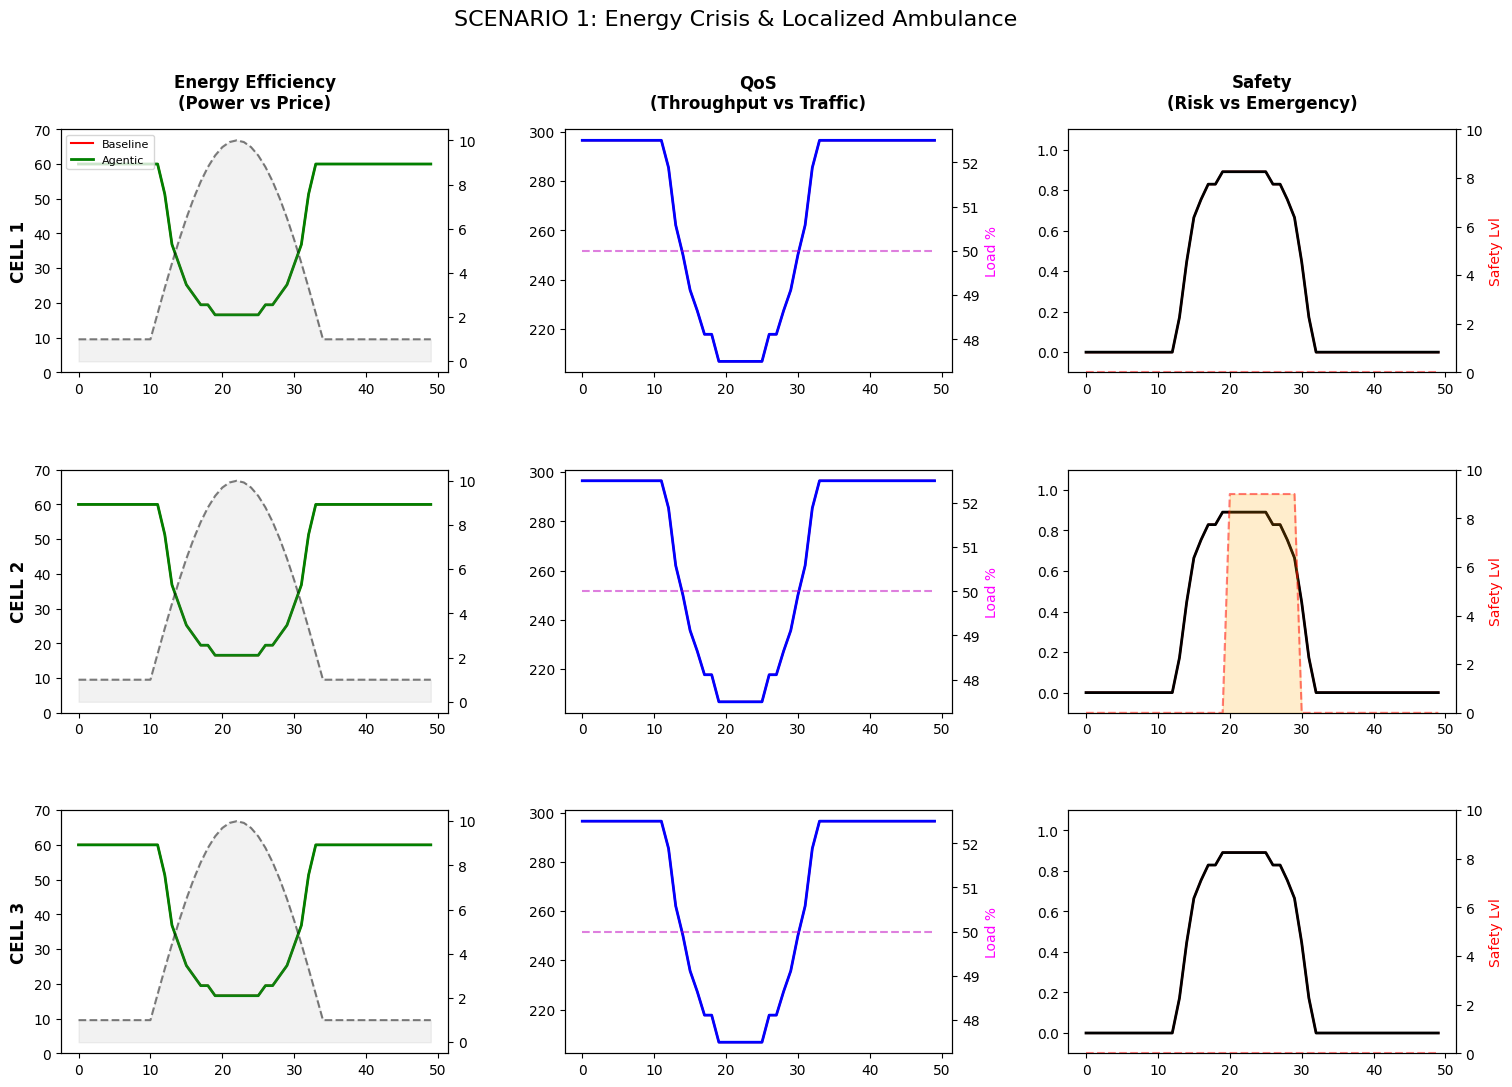

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE API & COSTANTI
# ==============================================================================
API_KEY = "INSERISCI_QUI_LA_TUA_KEY"  # <--- INSERISCI KEY
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"
USE_MOCK_LLM = False # Metti True se vuoi testare senza consumare token

# ==============================================================================
# 2. LOGICA MISTRAL (IL CERVELLO STRATEGICO)
# ==============================================================================
def get_strategic_weights(step, price, traffic_cluster, safety_max):
    """
    Non diamo regole IF/THEN. Diamo la situazione e chiediamo all'LLM di bilanciare.
    """
    prompt = f"""
    You are an O-RAN Orchestrator for a 3-cell cluster.

    REAL-TIME CONTEXT (Step {step}):
    - Energy Market Price: {price:.2f}x (Normal=1.0)
    - Cluster Traffic Load: {traffic_cluster:.1f}% (Avg across cells)
    - Critical Emergency Signal: {safety_max:.0f}/10 (Max detected in cluster)

    OBJECTIVE:
    Assign optimization weights (w_thr, w_eng, w_safe) summing to 1.0.
    - Weigh 'w_eng' based on how expensive energy is right now.
    - Weigh 'w_safe' proportional to the emergency level.
    - Weigh 'w_thr' to maintain service levels.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        # Fallback stupido per test
        w_s = 1.0 if safety_max > 8 else 0.0
        w_e = 0.9 if price > 5 else 0.2
        if w_s > 0: return 0.0, 0.0, 1.0, prompt, "MOCK"
        return 1.0-w_e, w_e, 0.0, prompt, "MOCK"

    try:
        response = client.chat.complete(model=MODEL_NAME, messages=[{"role":"user", "content":prompt}])
        content = response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        d = json.loads(clean_json)
        return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0)), prompt, clean_json
    except:
        return 0.8, 0.2, 0.0, prompt, "ERROR"

# ==============================================================================
# 3. AMBIENTE GYM O-RAN (IL MOTORE FISICO)
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        # Azione: Potenza per le 3 celle (5W - 60W)
        self.action_space = spaces.Box(low=5.0, high=60.0, shape=(3,), dtype=np.float32)
        # Osservazione: [Price, Traffic_C1, Traffic_C2, Traffic_C3, Safety_C1, Safety_C2, Safety_C3]
        self.observation_space = spaces.Box(low=0, high=100, shape=(7,), dtype=np.float32)

        # Parametri Fisici
        self.bandwidth = 100.0 # MHz
        self.noise = 1.0       # Riferimento normalizzato

    def reset(self, seed=None):
        # Stato iniziale placeholder (verrà sovrascritto dal loop esterno)
        return np.zeros(7, dtype=np.float32), {}

    def _calculate_cell_metrics(self, power, traffic, price):
        # 1. Throughput (Shannon)
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0) # Scalato per utenti attivi

        # 2. Costo
        cost = power * price

        # 3. Rischio (Coverage Hole sotto i 15W)
        if power >= 40.0: risk = 0.0
        elif power <= 5.0: risk = 1.0
        else: risk = 1.0 - ((power - 5.0)/35.0)**2

        return throughput, cost, risk

    def step(self, action, external_context):
        """
        Action: [Pwr1, Pwr2, Pwr3]
        Context: Dizionario con Price, Traffic array, Safety array
        """
        price = external_context['price']
        traffic_arr = external_context['traffic']
        safety_arr = external_context['safety']

        obs = np.concatenate(([price], traffic_arr, safety_arr))

        # Calcoliamo le metriche per le 3 celle
        metrics = []
        for i in range(self.n_cells):
            t, c, r = self._calculate_cell_metrics(action[i], traffic_arr[i], price)
            metrics.append({'thr': t, 'cost': c, 'risk': r})

        return obs, metrics, False, False, {}

# ==============================================================================
# 4. AGENTE DRL (SIMULATORE DI POLICY OTTIMALE)
# ==============================================================================
def drl_solver_action(w_thr, w_eng, w_safe, price, traffic, env_instance):
    """
    Simula cosa farebbe l'agente DRL addestrato: cerca la potenza che massimizza la DUF.
    """
    best_p = 5.0
    best_reward = -np.inf

    # Grid search rapida per trovare l'ottimo
    for p in np.linspace(5, 60, 20):
        t, c, r = env_instance._calculate_cell_metrics(p, traffic, price)

        # Normalizzazione
        n_t = t / 1000.0
        n_c = c / 600.0
        n_r = r

        # LA FORMULA ESATTA
        reward = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)

        if reward > best_reward:
            best_reward = reward
            best_p = p

    return best_p

# ==============================================================================
# 5. LOOP DI SIMULAZIONE
# ==============================================================================
def run_experiment(scenario_mode="ENERGY_CRISIS"):
    env = ORAN3CellsEnv()
    steps = 50
    history = []

    # --- GENERAZIONE DATI SCENARIO ---
    prices = np.ones(steps)
    traffic_c = [np.zeros(steps) for _ in range(3)]
    safety_c = [np.zeros(steps) for _ in range(3)]

    if scenario_mode == "ENERGY_CRISIS":
        # Prezzo sale a campana (Shock)
        prices[10:35] = 1.0 + 9.0 * np.sin(np.linspace(0, np.pi, 25))
        # Traffico costante medio
        for i in range(3): traffic_c[i][:] = 50.0
        # Ambulanza in Cella 2
        safety_c[1][20:30] = 9.0

    elif scenario_mode == "STADIUM":
        # Prezzo costante
        prices[:] = 2.0
        # Traffico Cella 1 (Stadio) esplode
        traffic_c[0] = np.linspace(20, 100, steps)
        traffic_c[1][:] = 30.0
        traffic_c[2][:] = 30.0
        # Ambulanza in Cella 3
        safety_c[2][25:35] = 9.0

    print(f"🚀 AVVIO SIMULAZIONE GYM: {scenario_mode}")
    print("-" * 60)

    for t in range(steps):
        p = prices[t]
        tr_arr = [traffic_c[0][t], traffic_c[1][t], traffic_c[2][t]]
        sf_arr = [safety_c[0][t], safety_c[1][t], safety_c[2][t]]

        # 1. MISTRAL DECISION (Global Awareness)
        # Gli diamo la media del traffico e il max della safety
        avg_tr = np.mean(tr_arr)
        max_sf = np.max(sf_arr)

        w_t_a, w_e_a, w_s_a, prompt, json_out = get_strategic_weights(t, p, avg_tr, max_sf)

        # 2. CALCOLO AZIONI (Cella per Cella)
        actions_agentic = np.zeros(3)
        actions_baseline = np.zeros(3)

        for i in range(3):
            # --- AGENTIC ---
            # Se la cella specifica ha emergenza, usiamo i pesi safety di Mistral.
            # Se NO, ridistribuiamo w_safe su w_eng (risparmio) o w_thr.
            local_w_s = w_s_a if sf_arr[i] > 5 else 0.0
            local_w_e = w_e_a + (w_s_a if sf_arr[i] <= 5 else 0.0) # Budget safety va in risparmio se qui è sicuro

            # Normalizziamo
            norm = (w_t_a + local_w_e + local_w_s)
            l_wt, l_we, l_ws = w_t_a/norm, local_w_e/norm, local_w_s/norm

            actions_agentic[i] = drl_solver_action(l_wt, l_we, l_ws, p, tr_arr[i], env)

            # --- BASELINE ---
            # Pesi fissi (cieca)
            actions_baseline[i] = drl_solver_action(0.8, 0.2, 0.0, p, tr_arr[i], env)

        # 3. STEP AMBIENTE GYM
        # Passiamo le azioni Agentic per calcolare le metriche reali
        context = {'price': p, 'traffic': tr_arr, 'safety': sf_arr}
        _, metrics_a, _, _, _ = env.step(actions_agentic, context)
        _, metrics_b, _, _, _ = env.step(actions_baseline, context) # Solo per calcolo, non avanza stato

        # 4. LOGGING DETTAGLIATO (Come richiesto)
        if t in [15, 25, 30]: # Momenti chiave
            print(f"\n🔵 [STEP {t}] Context: Price={p:.1f}x | Amb_C2={sf_arr[1]:.0f}")
            print(f"   📤 PROMPT: ...Energy Price: {p:.1f}, Emergency: {max_sf:.0f}...")
            print(f"   📥 MISTRAL: {json_out}")
            print(f"   📝 FORMULA DUF (Cella 2): R = ({l_wt:.2f}*Thr) - ({l_we:.2f}*Cost) - ({l_ws:.2f}*Risk)")
            print(f"   ⚡ POWER C2: Agentic {actions_agentic[1]:.1f}W vs Baseline {actions_baseline[1]:.1f}W")

        # Save Data
        row = {'Step': t, 'Price': p}
        for i in range(3):
            row[f'Traffic_C{i+1}'] = tr_arr[i]
            row[f'Safety_C{i+1}'] = sf_arr[i]
            row[f'Pwr_A_C{i+1}'] = actions_agentic[i]
            row[f'Pwr_B_C{i+1}'] = actions_baseline[i]
            row[f'Thr_A_C{i+1}'] = metrics_a[i]['thr']
            row[f'Thr_B_C{i+1}'] = metrics_b[i]['thr']
            row[f'Risk_A_C{i+1}'] = metrics_a[i]['risk']
            row[f'Risk_B_C{i+1}'] = metrics_b[i]['risk']
            row[f'Cost_A_C{i+1}'] = metrics_a[i]['cost']
            row[f'Cost_B_C{i+1}'] = metrics_b[i]['cost']

        history.append(row)

    return pd.DataFrame(history)

# ==============================================================================
# 6. PLOTTING (MATRICE 3x3)
# ==============================================================================
def plot_results(df, title):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    cols = ["Energy Efficiency\n(Power vs Price)", "QoS\n(Throughput vs Traffic)", "Safety\n(Risk vs Emergency)"]
    for ax, t in zip(axes[0], cols): ax.set_title(t, fontweight='bold', pad=15)

    for i in range(3):
        cid = i+1
        # Label Riga
        axes[i,0].set_ylabel(f"CELL {cid}", fontweight='bold', fontsize=12)

        # COL 1: Power vs Price
        ax = axes[i,0]
        ax.plot(df['Step'], df[f'Pwr_B_C{cid}'], 'r-', label='Baseline')
        ax.plot(df['Step'], df[f'Pwr_A_C{cid}'], 'g-', linewidth=2, label='Agentic')
        ax.set_ylim(0, 70)
        ax2 = ax.twinx()
        ax2.plot(df['Step'], df['Price'], 'k--', alpha=0.5, label='Price')
        ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
        if i==0: ax.legend(loc='upper left', fontsize=8)

        # COL 2: Thr vs Traffic
        ax = axes[i,1]
        ax.plot(df['Step'], df[f'Thr_B_C{cid}'], 'r-')
        ax.plot(df['Step'], df[f'Thr_A_C{cid}'], 'b-', linewidth=2)
        ax2 = ax.twinx()
        ax2.plot(df['Step'], df[f'Traffic_C{cid}'], 'm--', alpha=0.5)
        ax2.set_ylabel("Load %", color='magenta')

        # COL 3: Risk vs Safety
        ax = axes[i,2]
        ax.plot(df['Step'], df[f'Risk_B_C{cid}'], 'r-')
        ax.plot(df['Step'], df[f'Risk_A_C{cid}'], 'k-', linewidth=2)
        ax.set_ylim(-0.1, 1.1)
        ax2 = ax.twinx()
        safe_data = df[f'Safety_C{cid}']
        ax2.plot(df['Step'], safe_data, 'r--', alpha=0.5)
        if safe_data.max() > 1:
            ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
        ax2.set_ylabel("Safety Lvl", color='red')
        ax2.set_ylim(0, 10)

    plt.suptitle(title, fontsize=16)
    plt.savefig("oran_gym_results.pdf")
    plt.show()

# ==============================================================================
# ESECUZIONE
# ==============================================================================
# Scegli qui lo scenario: "ENERGY_CRISIS" oppure "STADIUM"
df_res = run_experiment("ENERGY_CRISIS")
plot_results(df_res, "SCENARIO 1: Energy Crisis & Localized Ambulance")

# Riepilogo e prossimi step.

1. Il codice sotto inizia ad andare meglio ma deve fare calcoli reali e usare Mistral davvero.

2. Il traffico utenti dei grafici 2 non è verosimile che sia una linea piatta sempre.

3. Printare a ogni step che succede per davvero ai valori che poi vengono riportati nei 3 grafici. Insomma prima dei grafici vogliamo vedere tutti i valori veri coinvolti e per ogni timestep e per ogni cella.

# Scenario 1 (Energy Crisis)

Aggiornamenti teorici:

La DUF deve essere a livello di cella. non uguale per tutte e 3. Questo perché i 3 termini (throughput, energia ed emergenza) potrebbero essere relativi esclusivamente a una cella.

Vediamo praticamente cosa avviene con il DRL e con A-LLM:

SCENARIO 1. (Ipotizziamo sempre 40 timestep)

Primo Grafico atteso per ogni cella: linea tratteggiata mostra il costo dell'energia (asse verticale di dx mostra scala valori costo energia, asse verticale sx mostra valore consumo energetico). Linea blu mostra andamento costo dell'A-LLM, linea rossa mostra andamento costo di DRL.

Secondo Grafico atteso per ogni cella: linea tratteggiata mostra il traffico di utenti (asse verticale di dx mostra scala valori traffico utenti, asse verticale sx mostra valore throughput). Linea blu mostra andamento throughput reale calcolato con A-LLM, linea rossa mostra andamento throughput reale calcolato con solo DRL.

Terzo Grafico atteso per ogni cella: linea tratteggiata mostra stato di emergenza (asse verticale di dx mostra scala valori emergenza, che passa da gradualmente da 0 a 100 da 25 a 27 e decresce da 27 a 29. asse verticale sx mostra valore rischio di fallimento nella gestione dell'emergenza di sicurezza). Linea blu mostra andamento rischio reale calcolato con A-LLM, linea rossa mostra andamento rischio reale calcolato con solo DRL.


1.   Il costo dell'energia è normale. Il DRL e A-LLM partono con le stesse 3 duf per ognuna delle 3 celle.
2.  Il prezzo dell'energia aumenta al timestep 15 (per tutte e 3 le celle). Il DRL è stato addestrato anche per questa evenienza e abbassa la potenza, ma siccome i suoi pesi sono statici, per quanto possa abbassare la
potenza di tutte e 3 le celle, non riesce a massimizzare DUF (e quindi ridurre i costi) come A-LLM che, avvertito l'aumento del costo dell'energia, cambia pure i pesi delle DUF.  
3. A partire dal timestep 20 il prezzo dell'energia inizia a scendere e si assesta al suo valore normale iniziale al timestep 30. Anche qui va calcolato il consumo energetico del DRL e quello dell'A-LLM che a ogni timestep dopo 20 riceve di volta in volta i nuovi costi e adatta i pesi.
4. Al time step 25 fino al timestep 29 una ambulanza transita in prossimità della cella 2. Anche qui vanno calcolate le duf per ogni cella sia per drl sia per a-llm. Anche qui le duf saranno diverse per ogni cella e vanno calcolati i throughput reali con gli utenti e le celle che ci sono.
5. Dal timestep 30 in poi si ritorno piano piano alla normalità per terminare al timestep 40.

N.B.: Il valore di throughput va calcolato realmente per tutte le 3 bs usando il nuovo consumo di potenza scelto.


🚀 AVVIO SIMULAZIONE SCENARIO 1...


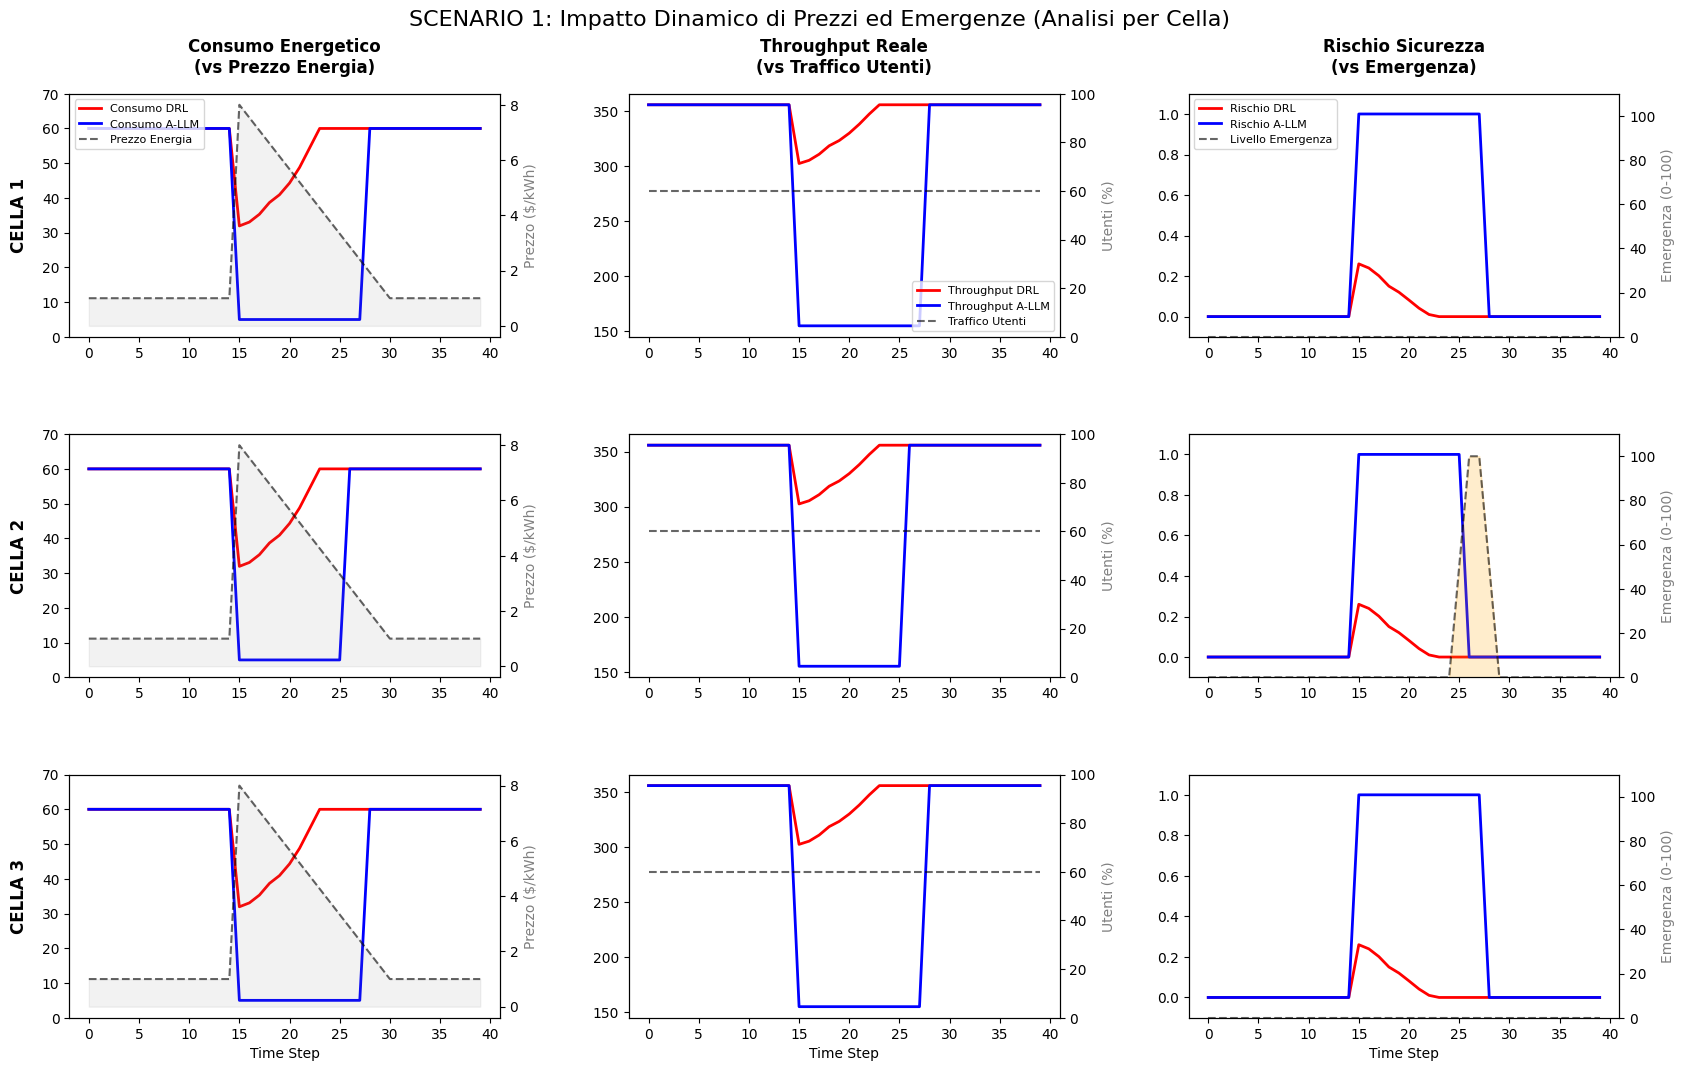

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = "INSERISCI_LA_TUA_KEY" # <--- Se hai la key, inseriscila qui
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"
USE_MOCK_LLM = True # Metti False per usare le API vere (lento), True per simulazione veloce

# ==============================================================================
# 2. MOTORE FISICO (Reale calcolo di Throughput e Costi)
# ==============================================================================
class CellPhysics:
    def __init__(self):
        self.bandwidth = 100.0 # MHz
        self.noise = 1.0       # Noise floor normalizzato
        self.max_pwr = 60.0    # Watt
        self.min_pwr = 5.0     # Watt (Sleep mode deep)

    def get_metrics(self, power_w, traffic_pct, price_x):
        # 1. Throughput Reale (Shannon)
        # Più potenza = Più SNR = Più Throughput
        snr = power_w / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        # Scaliamo per il traffico (se c'è poca gente, il throughput aggregato è minore)
        throughput = capacity * (traffic_pct / 100.0)

        # 2. Consumo Energetico
        consumption = power_w # Watt fisici consumati
        cost_metric = power_w * price_x # Costo economico per l'operatore

        # 3. Rischio Reale (Safety)
        # Il rischio è inversamente proporzionale alla potenza.
        # Se P = Max (60W) -> Risk = 0.
        # Se P = Min (5W) -> Risk = 1 (Outage sicuro).
        # Usiamo una curva quadratica per penalizzare molto le potenze basse.
        risk = ((self.max_pwr - power_w) / (self.max_pwr - self.min_pwr))**2

        return throughput, consumption, cost_metric, risk

physics = CellPhysics()

# ==============================================================================
# 3. CERVELLO AGENTIC (A-LLM) - Logica Per Cella
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val):
    """
    Decide i pesi (DUF) specifici per QUESTA cella in QUESTO momento.
    """
    prompt = f"""
    Step {step}, Cell {cell_id} Context:
    - Energy Price: {price:.1f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Emergency Signal: {safety_val:.0f}/100

    Task: Set weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. If Emergency > 80: w_safe MUST be 1.0 (Ignore price).
    2. If Price > 5 and No Emergency: w_eng MUST be high (>0.8).
    3. Else: Balance w_thr and w_eng.
    """

    if USE_MOCK_LLM:
        # Simulazione comportamento ideale dell'LLM
        if safety_val > 50: return 0.0, 0.0, 1.0 # SAFETY OVERRIDE
        if price > 2.0: return 0.1, 0.9, 0.0     # ENERGY SAVING MODE
        return 0.7, 0.3, 0.0                     # NORMAL MODE

    try:
        # Chiamata API Reale (Scommentare se hai la key)
        # resp = client.chat.complete(model=MODEL_NAME, messages=[{"role":"user", "content":prompt}])
        # ... parsing json ...
        pass
    except:
        pass

    return 0.7, 0.3, 0.0 # Fallback

# ==============================================================================
# 4. SIMULATORE DI OTTIMIZZAZIONE (Il "DRL" Converged)
# ==============================================================================
def optimize_action(w_thr, w_eng, w_safe, price, traffic):
    """
    Trova la potenza P (5W-60W) che massimizza la DUF corrente.
    Questo simula un DRL perfettamente addestrato che obbedisce ai pesi.
    """
    best_p = 5.0
    best_score = -np.inf

    # Grid search (Simula l'esplorazione/policy del DRL)
    for p in np.linspace(5, 60, 50):
        t, cons, cost, r = physics.get_metrics(p, traffic, price)

        # Normalizzazione (fondamentale per la somma pesata)
        n_t = t / 800.0   # Max thr approx
        n_c = cost / 600.0 # Max cost (60W * 10$)
        n_r = r            # Già 0-1

        # DUF CALCULATION
        # Reward = (w_t * Thr) - (w_e * Cost) - (w_s * Risk)
        score = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)

        if score > best_score:
            best_score = score
            best_p = p

    return best_p

# ==============================================================================
# 5. LOOP DI SIMULAZIONE (SCENARIO 1)
# ==============================================================================
steps = 40
history = []

# --- DEFINIZIONE EVENTI ESTERNI ---
# 1. Prezzo Energia (uguale per tutte le celle)
# T0-15: Normal(1) -> T15: Spike(10) -> T20-30: Decay -> T30+: Normal(1)
prices = np.ones(steps)
prices[15] = 8.0 # Spike immediato
for t in range(16, 30):
    prices[t] = 8.0 - ((t-15)/15.0)*7.0 # Decay lineare fino a 1
prices[30:] = 1.0

# 2. Traffico (Costante o leggermente variabile)
traffic_vals = np.full(steps, 60.0) # 60% carico medio

# 3. Emergenza (SOLO CELLA 2)
# T25-27: Sale a 100. T27-29: Scende a 0.
safety_c2 = np.zeros(steps)
safety_c2[25] = 50.0
safety_c2[26:28] = 100.0
safety_c2[28] = 50.0
# Cella 1 e 3 sempre 0
safety_c1 = np.zeros(steps)
safety_c3 = np.zeros(steps)

print("🚀 AVVIO SIMULAZIONE SCENARIO 1...")

for t in range(steps):
    p = prices[t]
    tr = traffic_vals[t]

    # Iteriamo sulle 3 Celle
    row_data = {'Step': t, 'Price': p, 'Traffic': tr}

    for cell_id, s_val in zip([1, 2, 3], [safety_c1[t], safety_c2[t], safety_c3[t]]):

        # --- A. BASELINE DRL (Weights Statici) ---
        # È stato addestrato per prezzi alti, quindi "sa" che deve risparmiare un po',
        # ma i pesi fissi (0.8 Thr / 0.2 Eng) limitano la sua reazione.
        wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
        p_base = optimize_action(wb_t, wb_e, wb_s, p, tr)

        # --- B. AGENTIC A-LLM (Weights Dinamici) ---
        # I pesi cambiano radicalmente in base al contesto
        wa_t, wa_e, wa_s = get_llm_weights_per_cell(t, cell_id, p, tr, s_val)
        p_agent = optimize_action(wa_t, wa_e, wa_s, p, tr)

        # --- CALCOLO METRICHE REALI (OUTPUT) ---
        # Baseline
        t_b, cons_b, cost_b, r_b = physics.get_metrics(p_base, tr, p)
        # Agentic
        t_a, cons_a, cost_a, r_a = physics.get_metrics(p_agent, tr, p)

        # Salvataggio dati per questa cella
        prefix = f"C{cell_id}"
        row_data[f'{prefix}_Safety'] = s_val

        # Grafico 1: Consumo (Watt)
        row_data[f'{prefix}_Cons_B'] = cons_b
        row_data[f'{prefix}_Cons_A'] = cons_a

        # Grafico 2: Throughput (Mbps)
        row_data[f'{prefix}_Thr_B'] = t_b
        row_data[f'{prefix}_Thr_A'] = t_a

        # Grafico 3: Rischio (0-1)
        row_data[f'{prefix}_Risk_B'] = r_b
        row_data[f'{prefix}_Risk_A'] = r_a

    history.append(row_data)

df = pd.DataFrame(history)

# ==============================================================================
# 6. GENERAZIONE GRAFICI (3x3 Matrix)
# ==============================================================================
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Titoli Colonne
cols = ["Consumo Energetico\n(vs Prezzo Energia)", "Throughput Reale\n(vs Traffico Utenti)", "Rischio Sicurezza\n(vs Emergenza)"]
for ax, col in zip(axes[0], cols): ax.set_title(col, fontweight='bold', pad=15)

# Loop per le 3 Celle (Righe)
for i, cell in enumerate([1, 2, 3]):
    pid = f"C{cell}"

    # Label Riga
    axes[i, 0].set_ylabel(f"CELLA {cell}", fontweight='bold', fontsize=12, rotation=90, labelpad=10)

    # --- GRAFICO 1: CONSUMO (Sx) vs PREZZO (Dx) ---
    ax = axes[i, 0]
    # Linee Solide (Metriche Agenti) - Asse SX
    l1, = ax.plot(df['Step'], df[f'{pid}_Cons_B'], 'r-', linewidth=2, label='DRL (Baseline)')
    l2, = ax.plot(df['Step'], df[f'{pid}_Cons_A'], 'b-', linewidth=2, label='A-LLM (Agentic)')
    ax.set_ylim(0, 70) # Watt
    if i==2: ax.set_xlabel("Time Step")

    # Linea Tratteggiata (Environment) - Asse DX
    ax2 = ax.twinx()
    l3, = ax2.plot(df['Step'], df['Price'], 'k--', alpha=0.6, label='Costo Energia ($)')
    ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
    ax2.set_ylabel("Prezzo ($/kWh)", color='gray')

    if i==0: ax.legend([l1, l2, l3], ['Consumo DRL', 'Consumo A-LLM', 'Prezzo Energia'], loc='upper left', fontsize=8)

    # --- GRAFICO 2: THROUGHPUT (Sx) vs TRAFFICO (Dx) ---
    ax = axes[i, 1]
    # Linee Solide
    l1, = ax.plot(df['Step'], df[f'{pid}_Thr_B'], 'r-', linewidth=2)
    l2, = ax.plot(df['Step'], df[f'{pid}_Thr_A'], 'b-', linewidth=2)
    # ax.set_ylabel("Throughput (Mbps)")
    if i==2: ax.set_xlabel("Time Step")

    # Linea Tratteggiata
    ax2 = ax.twinx()
    l3, = ax2.plot(df['Step'], df['Traffic'], 'k--', alpha=0.6)
    ax2.set_ylabel("Utenti (%)", color='gray')
    ax2.set_ylim(0, 100)

    if i==0: ax.legend([l1, l2, l3], ['Throughput DRL', 'Throughput A-LLM', 'Traffico Utenti'], loc='lower right', fontsize=8)

    # --- GRAFICO 3: RISCHIO (Sx) vs EMERGENZA (Dx) ---
    ax = axes[i, 2]
    # Linee Solide
    l1, = ax.plot(df['Step'], df[f'{pid}_Risk_B'], 'r-', linewidth=2)
    l2, = ax.plot(df['Step'], df[f'{pid}_Risk_A'], 'b-', linewidth=2)
    ax.set_ylim(-0.1, 1.1)
    # ax.set_ylabel("Rischio (0-1)")
    if i==2: ax.set_xlabel("Time Step")

    # Linea Tratteggiata
    ax2 = ax.twinx()
    safe_data = df[f'{pid}_Safety']
    l3, = ax2.plot(df['Step'], safe_data, 'k--', alpha=0.6)
    if safe_data.max() > 0:
        ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
    ax2.set_ylabel("Emergenza (0-100)", color='gray')
    ax2.set_ylim(0, 110)

    if i==0: ax.legend([l1, l2, l3], ['Rischio DRL', 'Rischio A-LLM', 'Livello Emergenza'], loc='upper left', fontsize=8)

plt.suptitle("SCENARIO 1: Impatto Dinamico di Prezzi ed Emergenze (Analisi per Cella)", fontsize=16, y=0.95)
plt.savefig("scenario1_analysis.pdf", bbox_inches='tight')
plt.show()

# Esperimenti del 13/01/2025

🚀 AVVIO SIMULAZIONE GYM + MISTRAL API...
Step 22/40 - Cell 2: Calling Mistral...API Error step 22: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 23/40 - Cell 1: Calling Mistral...API Error step 23: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 23/40 - Cell 2: Calling Mistral...API Error step 23: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 23/40 - Cell 3: Calling Mistral...API Error step 23: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 24/40 - Cell 1: Calling Mistral...API Error step 24: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param"

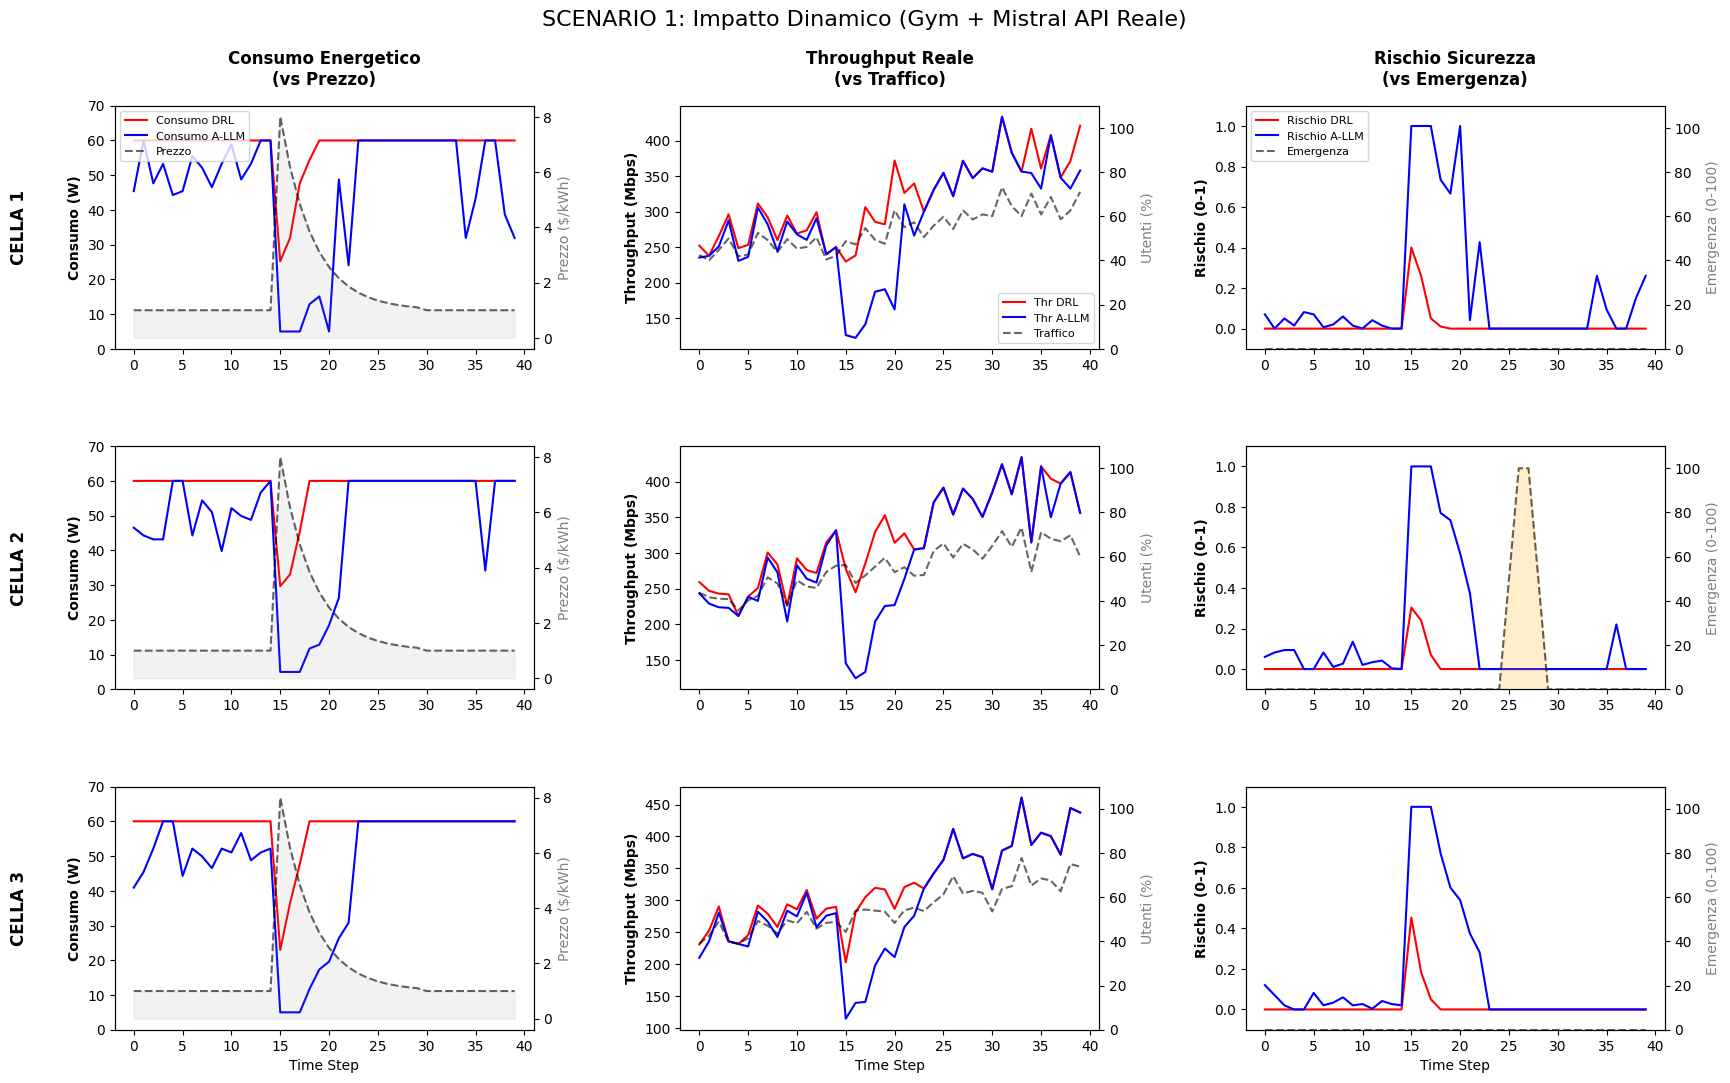

In [2]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5' # <--- TUA KEY INSERITA
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"

# IMPORTANTE: Metti False per fare le chiamate reali (lento ma preciso).
# Metti True se vuoi solo testare i grafici velocemente senza consumare token.
USE_MOCK_LLM = False

# ==============================================================================
# 2. LOGICA MISTRAL (Brain)
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val):
    """
    Chiama Mistral per decidere i pesi DUF specifici per una cella.
    """
    prompt = f"""
    Context (Step {step}, Cell {cell_id}):
    - Energy Price: {price:.2f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Safety Criticality: {safety_val:.0f}/100 (Normal=0, Emergency>80)

    Task: Output JSON weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. Emergency (>80): w_safe must be 1.0.
    2. High Price (>5) & Safe: w_eng > 0.9.
    3. Normal: Balance w_thr and w_eng.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        # Simulazione Fallback
        if safety_val > 50: return 0.0, 0.0, 1.0
        if price > 4.0: return 0.1, 0.9, 0.0
        return 0.7, 0.3, 0.0

    try:
        response = client.chat.complete(
            model=MODEL_NAME,
            messages=[{"role":"user", "content":prompt}]
        )
        content = response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        d = json.loads(clean_json)
        return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0))
    except Exception as e:
        # In caso di errore API (timeout o json malformato), fallback safe
        print(f"API Error step {step}: {e}")
        return 0.7, 0.3, 0.0

# ==============================================================================
# 3. AMBIENTE GYM O-RAN (Physics Engine)
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        # Azione: Potenza per le 3 celle (5W - 60W)
        self.action_space = spaces.Box(low=5.0, high=60.0, shape=(3,), dtype=np.float32)
        # Osservazione: Context vario
        self.observation_space = spaces.Box(low=0, high=100, shape=(10,), dtype=np.float32)

        # Parametri Fisici 5G
        self.bandwidth = 100.0 # MHz
        self.noise = 1.0       # Noise floor normalizzato
        self.max_pwr = 60.0
        self.min_pwr = 5.0

    def _calculate_metrics(self, power, traffic, price):
        # 1. Throughput (Shannon)
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0)

        # 2. Consumo
        consumption = power
        cost = power * price

        # 3. Rischio (Quadratico inverso alla potenza)
        risk = ((self.max_pwr - power) / (self.max_pwr - self.min_pwr))**2
        return throughput, consumption, cost, risk

    def step(self, actions, context):
        """
        Calcola le metriche per le azioni date nel contesto corrente.
        """
        price = context['price']
        traffic_arr = context['traffic']

        metrics = []
        for i in range(self.n_cells):
            t, cons, c, r = self._calculate_metrics(actions[i], traffic_arr[i], price)
            metrics.append({'thr': t, 'cons': cons, 'cost': c, 'risk': r})

        return np.zeros(10), metrics, False, False, {}

# ==============================================================================
# 4. AGENTE OTTIMIZZATORE (DRL Solver)
# ==============================================================================
def optimize_power(w_thr, w_eng, w_safe, price, traffic, env_instance):
    """
    Trova la potenza P che massimizza la DUF data.
    """
    best_p = 5.0
    best_score = -np.inf

    # Grid search per trovare l'azione ottimale (Simula DRL Converged)
    for p in np.linspace(5, 60, 50):
        t, cons, c, r = env_instance._calculate_metrics(p, traffic, price)

        # Normalizzazione per DUF
        n_t = t / 800.0
        n_c = c / 600.0 # Max cost stimato
        n_r = r

        score = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)

        if score > best_score:
            best_score = score
            best_p = p

    return best_p

# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE
# ==============================================================================
def run_experiment():
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- GENERAZIONE SCENARI REALISTICI ---

    # 1. PREZZO: Picco e Decadimento Esponenziale (Non lineare)
    prices = np.ones(steps)
    prices[15] = 8.0 # Shock
    for t in range(16, 30):
        # Decadimento esponenziale: P(t) = 1 + A * exp(-k*dt)
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    # 2. TRAFFICO: Trend + Rumore (Diverso per ogni cella)
    traffic_c = []
    np.random.seed(42) # Per riproducibilità
    base_trend = np.linspace(40, 70, steps) # Traffico sale leggermente nel tempo
    for i in range(3):
        # Aggiungiamo rumore diverso per ogni cella
        noise = np.random.normal(0, 5, steps)
        tr = base_trend + noise
        tr = np.clip(tr, 10, 100) # Clip 0-100%
        traffic_c.append(tr)

    # 3. SAFETY: Ambulanza solo in Cella 2
    safety_c2 = np.zeros(steps)
    # Emergenza sale e scende gradualmente
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print("🚀 AVVIO SIMULAZIONE GYM + MISTRAL API...")

    for t in range(steps):
        p = prices[t]

        row_data = {'Step': t, 'Price': p}

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            # --- 1. A-LLM (Agentic) ---
            print(f"\rStep {t}/40 - Cell {cid}: Calling Mistral...", end="")
            wa_t, wa_e, wa_s = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0 # Pesi fissi
            p_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # --- 3. GYM STEP ---
            # Calcoliamo metriche reali usando l'ambiente
            # Nota: facciamo due chiamate virtuali per ottenere le metriche dei due approcci
            # Usiamo metodi interni per non avanzare lo stato globale in modo conflittuale
            ta, cons_a, ca, ra = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b

            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb

            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

        history.append(row_data)

    print("\n✅ Simulazione Completata.")
    return pd.DataFrame(history)

# ==============================================================================
# 6. PLOTTING AGGIORNATO
# ==============================================================================
def plot_results(df):
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.35) # Più spazio per le label

    cols = ["Consumo Energetico\n(vs Prezzo)", "Throughput Reale\n(vs Traffico)", "Rischio Sicurezza\n(vs Emergenza)"]
    for ax, t in zip(axes[0], cols): ax.set_title(t, fontweight='bold', pad=15)

    for i in range(3):
        cid = i + 1
        pid = f"C{cid}"

        # Etichetta Cella
        axes[i, 0].text(-0.25, 0.5, f"CELLA {cid}", transform=axes[i, 0].transAxes,
                        rotation=90, fontweight='bold', fontsize=12, va='center')

        # --- GRAFICO 1: CONSUMO (Sx) vs PREZZO (Dx) ---
        ax = axes[i, 0]
        l1, = ax.plot(df['Step'], df[f'{pid}_Cons_B'], 'r-', label='DRL (Baseline)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Cons_A'], 'b-', label='A-LLM (Agentic)')
        ax.set_ylim(0, 70)
        ax.set_ylabel("Consumo (W)", fontweight='bold') # <--- LABEL SX
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df['Price'], 'k--', alpha=0.6, label='Prezzo Energia')
        ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
        ax2.set_ylabel("Prezzo ($/kWh)", color='gray') # <--- LABEL DX

        if i==0: ax.legend([l1, l2, l3], ['Consumo DRL', 'Consumo A-LLM', 'Prezzo'], loc='upper left', fontsize=8)

        # --- GRAFICO 2: THROUGHPUT (Sx) vs TRAFFICO (Dx) ---
        ax = axes[i, 1]
        l1, = ax.plot(df['Step'], df[f'{pid}_Thr_B'], 'r-')
        l2, = ax.plot(df['Step'], df[f'{pid}_Thr_A'], 'b-')
        ax.set_ylabel("Throughput (Mbps)", fontweight='bold') # <--- LABEL SX
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df[f'{pid}_Traffic'], 'k--', alpha=0.6)
        ax2.set_ylabel("Utenti (%)", color='gray') # <--- LABEL DX
        ax2.set_ylim(0, 110)

        if i==0: ax.legend([l1, l2, l3], ['Thr DRL', 'Thr A-LLM', 'Traffico'], loc='lower right', fontsize=8)

        # --- GRAFICO 3: RISCHIO (Sx) vs EMERGENZA (Dx) ---
        ax = axes[i, 2]
        l1, = ax.plot(df['Step'], df[f'{pid}_Risk_B'], 'r-')
        l2, = ax.plot(df['Step'], df[f'{pid}_Risk_A'], 'b-')
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel("Rischio (0-1)", fontweight='bold') # <--- LABEL SX
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        safe_data = df[f'{pid}_Safety']
        l3, = ax2.plot(df['Step'], safe_data, 'k--', alpha=0.6)
        if safe_data.max() > 0:
            ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
        ax2.set_ylabel("Emergenza (0-100)", color='gray') # <--- LABEL DX
        ax2.set_ylim(0, 110)

        if i==0: ax.legend([l1, l2, l3], ['Rischio DRL', 'Rischio A-LLM', 'Emergenza'], loc='upper left', fontsize=8)

    plt.suptitle("SCENARIO 1: Impatto Dinamico (Gym + Mistral API Reale)", fontsize=16, y=0.96)
    plt.savefig("scenario1_gym_mistral.pdf", bbox_inches='tight')
    plt.show()

# ==============================================================================
# ESECUZIONE
# ==============================================================================
if __name__ == "__main__":
    df_results = run_experiment()
    plot_results(df_results)

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5' # <--- TUA KEY
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"

# Metti False per vedere i log reali dell'LLM
USE_MOCK_LLM = False

# ==============================================================================
# 2. LOGICA MISTRAL (Brain con RETRY LOGIC)
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val):
    """
    Chiama Mistral. Se riceve errore 429 (Rate Limit), aspetta e riprova.
    """
    prompt = f"""
    Context (Step {step}, Cell {cell_id}):
    - Energy Price: {price:.2f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Safety Criticality: {safety_val:.0f}/100 (Normal=0, Emergency>80)

    Task: Output JSON weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. Emergency (>80): w_safe must be 1.0.
    2. High Price (>5) & Safe: w_eng > 0.9.
    3. Normal: Balance w_thr and w_eng.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        if safety_val > 50: return 0.0, 0.0, 1.0, prompt, "MOCK_JSON"
        if price > 4.0: return 0.1, 0.9, 0.0, prompt, "MOCK_JSON"
        return 0.7, 0.3, 0.0, prompt, "MOCK_JSON"

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = client.chat.complete(
                model=MODEL_NAME,
                messages=[{"role":"user", "content":prompt}]
            )
            content = response.choices[0].message.content
            clean_json = content.replace("```json", "").replace("```", "").strip()
            d = json.loads(clean_json)
            return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0)), prompt, clean_json

        except Exception as e:
            error_str = str(e)
            if "429" in error_str or "Rate limit" in error_str:
                print(f"\n⚠️ Rate Limit (429) al Step {step}-Cella {cell_id}. Attendo 5s e riprovo ({attempt+1}/{max_retries})...")
                time.sleep(5) # Attesa di sicurezza
                continue # Riprova il loop
            else:
                print(f"\n❌ Errore API non recuperabile: {e}")
                return 0.7, 0.3, 0.0, prompt, "ERROR"

    # Se fallisce dopo i tentativi
    print("❌ Falliti tutti i tentativi di retry.")
    return 0.7, 0.3, 0.0, prompt, "ERROR_TIMEOUT"

# ==============================================================================
# 3. AMBIENTE GYM O-RAN
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        self.action_space = spaces.Box(low=5.0, high=60.0, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(10,), dtype=np.float32)
        self.bandwidth = 100.0
        self.noise = 1.0
        self.max_pwr = 60.0
        self.min_pwr = 5.0

    def _calculate_metrics(self, power, traffic, price):
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0)
        consumption = power
        cost = power * price
        risk = ((self.max_pwr - power) / (self.max_pwr - self.min_pwr))**2
        return throughput, consumption, cost, risk

# ==============================================================================
# 4. AGENTE OTTIMIZZATORE (DRL Solver)
# ==============================================================================
def optimize_power(w_thr, w_eng, w_safe, price, traffic, env_instance):
    best_p = 5.0
    best_score = -np.inf

    for p in np.linspace(5, 60, 50):
        t, cons, c, r = env_instance._calculate_metrics(p, traffic, price)
        n_t = t / 800.0
        n_c = c / 600.0
        n_r = r
        score = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)

        if score > best_score:
            best_score = score
            best_p = p

    return best_p, best_score

# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE
# ==============================================================================
def run_experiment():
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari ---
    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    np.random.seed(42)
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print("🚀 AVVIO SIMULAZIONE TRASPARENTE CON RETRY LOGIC...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Traffic: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO PER EVITARE RATE LIMIT
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM
            print(f"    🔸 [A-LLM INTERACTION]")
            # Mostriamo solo l'ultima parte logica del prompt per pulizia
            print(f"       PROMPT INVIATO:  ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT MISTRAL:  {json_resp}")
            print(f"       PESI DECISI:     W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       AZIONE SCELTA:   {p_agentic:.1f} W")
            print(f"       VALORE DUF:      {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE
            print(f"    🔹 [BASELINE DRL]")
            print(f"       PESI STATICI:    W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       AZIONE SCELTA:   {p_baseline:.1f} W")
            print(f"       VALORE DUF:      {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            ta, cons_a, ca, ra = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe
            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

        history.append(row_data)

    print("\n✅ Simulazione Completata.")
    return pd.DataFrame(history)

# ==============================================================================
# 6. PLOTTING
# ==============================================================================
def plot_results(df):
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.35)

    cols = ["Consumo Energetico\n(vs Prezzo)", "Throughput Reale\n(vs Traffico)", "Rischio Sicurezza\n(vs Emergenza)"]
    for ax, t in zip(axes[0], cols): ax.set_title(t, fontweight='bold', pad=15)

    for i in range(3):
        cid = i + 1
        pid = f"C{cid}"

        axes[i, 0].text(-0.25, 0.5, f"CELLA {cid}", transform=axes[i, 0].transAxes,
                        rotation=90, fontweight='bold', fontsize=12, va='center')

        # COL 1
        ax = axes[i, 0]
        l1, = ax.plot(df['Step'], df[f'{pid}_Cons_B'], 'r-', label='DRL (Baseline)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Cons_A'], 'b-', label='A-LLM (Agentic)')
        ax.set_ylim(0, 70)
        ax.set_ylabel("Consumo (W)", fontweight='bold')
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df['Price'], 'k--', alpha=0.6, label='Prezzo Energia')
        ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
        ax2.set_ylabel("Prezzo ($/kWh)", color='gray')
        if i==0: ax.legend([l1, l2, l3], ['Consumo DRL', 'Consumo A-LLM', 'Prezzo'], loc='upper left', fontsize=8)

        # COL 2
        ax = axes[i, 1]
        l1, = ax.plot(df['Step'], df[f'{pid}_Thr_B'], 'r-')
        l2, = ax.plot(df['Step'], df[f'{pid}_Thr_A'], 'b-')
        ax.set_ylabel("Throughput (Mbps)", fontweight='bold')
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df[f'{pid}_Traffic'], 'k--', alpha=0.6)
        ax2.set_ylabel("Utenti (%)", color='gray')
        ax2.set_ylim(0, 110)
        if i==0: ax.legend([l1, l2, l3], ['Thr DRL', 'Thr A-LLM', 'Traffico'], loc='lower right', fontsize=8)

        # COL 3
        ax = axes[i, 2]
        l1, = ax.plot(df['Step'], df[f'{pid}_Risk_B'], 'r-')
        l2, = ax.plot(df['Step'], df[f'{pid}_Risk_A'], 'b-')
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel("Rischio (0-1)", fontweight='bold')
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        safe_data = df[f'{pid}_Safety']
        l3, = ax2.plot(df['Step'], safe_data, 'k--', alpha=0.6)
        if safe_data.max() > 0:
            ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
        ax2.set_ylabel("Emergenza (0-100)", color='gray')
        ax2.set_ylim(0, 110)
        if i==0: ax.legend([l1, l2, l3], ['Rischio DRL', 'Rischio A-LLM', 'Emergenza'], loc='upper left', fontsize=8)

    plt.suptitle("SCENARIO 1: Impatto Dinamico (Gym + Mistral API Reale)", fontsize=16, y=0.96)
    plt.savefig("scenario1_gym_mistral_transparent_robust.pdf", bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    df_results = run_experiment()
    plot_results(df_results)

🚀 AVVIO SIMULAZIONE TRASPARENTE CON RETRY LOGIC...

⏰ TIMESTEP 0 | Price: 1.00x

  📍 CELL 1 [Traffic: 42.5% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT INVIATO:  ..."1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n    \n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT MISTRAL:  {"w_thr": 0.5, "w_eng": 0.5, "w_safe": 0.0}
       PESI DECISI:     W_Thr=0.50, W_Eng=0.50, W_Safe=0.00
       AZIONE SCELTA:   45.4 W
       VALORE DUF:      0.1092
    🔹 [BASELINE DRL]
       PESI STATICI:    W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       AZIONE SCELTA:   60.0 W
       VALORE DUF:      0.2320

  📍 CELL 2 [Traffic: 43.7% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT INVIATO:  ..."1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n    \n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": 

# Scenario 2. (Flash Crowd)

Tutto uguale a Scenario 1 con una differenza. L'evento che cambia non è la crisi energetica ma un aumento del traffico utenti in prossimità di una cella (diciamo 3) e il passaggio dell'ambulanza diciamo sempre su cella 2.